# インポート

In [2]:
#インポート文
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import pydata_google_auth
from google.cloud import bigquery

# BigQueryからデータの読み込み

In [3]:
credentials = pydata_google_auth.get_user_credentials(
    ['https://www.googleapis.com/auth/bigquery'],
)
client = bigquery.Client(project='keiba-381006', credentials=credentials)

In [4]:
race_query = '''
    SELECT * 
    FROM tennosyoharu.race_table
    '''
race_df = client.query(race_query).to_dataframe()
race_df.head(1)

,race_id,race_round,race_title,weather,ground_status,date,where_racecourse,total_horse_number,frame_number_first,horse_number_first,...,wide_2_3,umatan,renhuku3,rentan3,race_rank,is_obstacle,ground_type,is_left_right_straight,distance,datetime
0,200908030410,10,第139回天皇賞(春)(G1),2,1,2009-05-03,8,18,1,2,...,1360,22530,32390,221080,0,0,2,2,3200,2009-05-03 15:40:00+00:00


In [5]:
horse_query = '''
    SELECT * 
    FROM tennosyoharu.horse_table 
    '''
horse_df = client.query(horse_query).to_dataframe()
pd.set_option('display.max_columns', 100)
horse_df.head(1)

,race_id,rank,frame_number,horse_number,horse_id,burden_weight,rider_id,goal_time,goal_time_dif,half_way_rank,last_time,odds,popular,horse_weight,tamer_id,owner_id,is_down,age,sex,horse_weight_dif,burden_weight_rate,avg_velocity
0,200808030411,14,4,6,2003102976,58.0,1014,199.0,0.3,5.0,38,434,11,512,362,398002,0,5,0,0,0.113281,16.080402


In [6]:
horse_info_query = '''
    SELECT * 
    FROM tennosyoharu.horse_info_table
    '''
horse_info_df = client.query(horse_info_query).to_dataframe()
pd.set_option('display.max_columns', 100)
horse_info_df.head(1)

,horse_id,bday,tamer_id,owner_id,producer_id,production_area,lifetime_record,wined_race_title,inbreeding_1,inbreeding_2,father,faths_father,faths_mother,mother,moths_father,moths_mother
0,1998105900,1998-03-21,05610,x0063a,910124.0,門別町,94戦13勝 [13-12-5-64],200205010111,1996102520,1.997106e+09,000a000082,000a0012cb,000a00877c,000a00005d,000a001607,000a00997a


In [7]:
horse_race_query = '''
    SELECT * 
    FROM tennosyoharu.horse_race_table
    '''
horse_race_df = client.query(horse_race_query).to_dataframe()
pd.set_option('display.max_columns', 100)
horse_race_df.head(1)

,date,where_racecourse,weather,race_round,race_title,race_id,total_horse_number,frame_number,horse_number,odds,popular,rank,rider_id,burden_weight,ground_status,goal_time,goal_time_dif,half_way_rank,pace,last_time,horse_weight,wined_horse_id,horse_id,target_race_id,race_rank,horse_weight_dif,is_down,burden_weight_rate,is_obstacle,ground_type,is_left_right_straight,distance,race_date
0,2016-05-28,5,2,11,欅S(OP),201605021111,16,1,1,380,9,7,1075,56.0,2,83.3,-0.3,9.5,35.5,36,472.0,2011104416,2010106467,201808030411,0,10.0,0,0.118644,0,1,0,1400,2018-04-29


In [8]:
#dfのマージ
df_marged = pd.DataFrame()
df_marged = pd.merge(horse_df, race_df, on='race_id', how='left')
df_marged = pd.merge(df_marged, horse_info_df, on='horse_id', how='left')
#df_marged = pd.merge(df_marged, horse_race_df, on='horse_id', how='left')
#過去のレースは1対多の関係にあるので、過去のレースの傾向から、今回のレースの調子を測る
df_marged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 514 entries, 0 to 513
Data columns (total 68 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   race_id                 514 non-null    Int64              
 1   rank                    514 non-null    Int64              
 2   frame_number            514 non-null    Int64              
 3   horse_number            514 non-null    Int64              
 4   horse_id                514 non-null    Int64              
 5   burden_weight           514 non-null    float64            
 6   rider_id                514 non-null    Int64              
 7   goal_time               514 non-null    float64            
 8   goal_time_dif           514 non-null    float64            
 9   half_way_rank           514 non-null    float64            
 10  last_time               514 non-null    Int64              
 11  odds                    514 non-null    Int64

# EDA

## race_dfの探索

### 全体

In [9]:
pd.set_option('display.max_columns', 100)
race_df_head = race_df.head(5)
race_df_head

,race_id,race_round,race_title,weather,ground_status,date,where_racecourse,total_horse_number,frame_number_first,horse_number_first,frame_number_second,horse_number_second,frame_number_third,horse_number_third,tansyo,hukusyo_first,hukusyo_second,hukusyo_third,wakuren,umaren,wide_1_2,wide_1_3,wide_2_3,umatan,renhuku3,rentan3,race_rank,is_obstacle,ground_type,is_left_right_straight,distance,datetime
0,200908030410,10,第139回天皇賞(春)(G1),2,1,2009-05-03,8,18,1,2,2,4,6,12,4650,870,270,370,3520,10200,2690,4370,1360,22530,32390,221080,0,0,2,2,3200,2009-05-03 15:40:00+00:00
1,201108030411,11,第143回天皇賞(春)(G1),2,2,2011-05-01,8,18,1,2,7,15,2,3,1690,550,300,450,2970,6810,2280,2560,1600,15590,25530,189840,0,0,2,2,3200,2011-05-01 15:40:00+00:00
2,201208030411,11,第145回天皇賞(春)(G1),1,1,2012-04-29,8,18,1,1,8,16,6,11,15960,3720,400,350,3580,61570,8400,8870,760,208630,97140,1452520,0,0,2,2,3200,2012-04-29 15:40:00+00:00
3,201508030411,11,第151回天皇賞(春)(G1),1,1,2015-05-03,8,17,1,1,7,14,1,2,460,260,630,610,690,6060,2300,2460,6010,8480,57160,236300,0,0,2,2,3200,2015-05-03 15:40:00+00:00
4,201608030411,11,第153回天皇賞(春)(G1),1,1,2016-05-01,8,18,1,1,2,3,4,8,450,170,1390,240,6650,20160,3770,540,7840,29950,32350,242730,0,0,2,2,3200,2016-05-01 15:40:00+00:00


In [10]:
def TablePlot(df,w,h):
    fig, ax = plt.subplots(figsize=(w,h))
    ax.axis('off')
    ax.table(
        df.values,
        colLabels = df.columns,
        loc = 'center',
        bbox=[0,0,1,1]
    )
    #plt.savefig(outputPath)
    plt.show()

c:\Users\kawam\miniforge3\envs\keiba-django\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 31532 (\N{CJK UNIFIED IDEOGRAPH-7B2C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\kawam\miniforge3\envs\keiba-django\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22238 (\N{CJK UNIFIED IDEOGRAPH-56DE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\kawam\miniforge3\envs\keiba-django\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22825 (\N{CJK UNIFIED IDEOGRAPH-5929}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\kawam\miniforge3\envs\keiba-django\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30343 (\N{CJK UNIFIED IDEOGRAPH-7687}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\kawam\miniforge3\envs\keiba-django\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 360

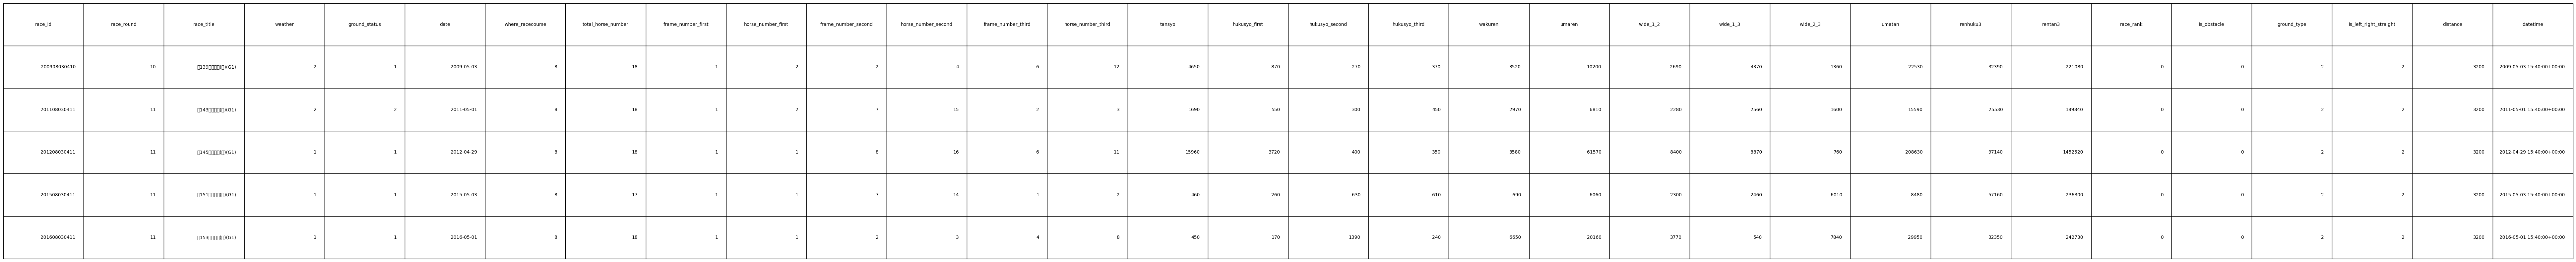

In [11]:
TablePlot(race_df_head,100,10)

In [12]:
race_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   race_id                 17 non-null     Int64              
 1   race_round              17 non-null     Int64              
 2   race_title              17 non-null     object             
 3   weather                 17 non-null     Int64              
 4   ground_status           17 non-null     Int64              
 5   date                    17 non-null     dbdate             
 6   where_racecourse        17 non-null     Int64              
 7   total_horse_number      17 non-null     Int64              
 8   frame_number_first      17 non-null     Int64              
 9   horse_number_first      17 non-null     Int64              
 10  frame_number_second     17 non-null     Int64              
 11  horse_number_second     17 non-null     Int64  

In [13]:
#合計の多い順にソート
null_total = race_df.isnull().sum().sort_values(ascending=False)
null_total

race_id                   0
race_round                0
distance                  0
is_left_right_straight    0
ground_type               0
is_obstacle               0
race_rank                 0
rentan3                   0
renhuku3                  0
umatan                    0
wide_2_3                  0
wide_1_3                  0
wide_1_2                  0
umaren                    0
wakuren                   0
hukusyo_third             0
hukusyo_second            0
hukusyo_first             0
tansyo                    0
horse_number_third        0
frame_number_third        0
horse_number_second       0
frame_number_second       0
horse_number_first        0
frame_number_first        0
total_horse_number        0
where_racecourse          0
date                      0
ground_status             0
weather                   0
race_title                0
datetime                  0
dtype: int64

race_dfには32個の特徴量が存在し、過去の対象レース情報が入っている  
それぞれのレースの特徴量から、レースの展開や荒れ具合などの傾向を調べると、競走馬の順位予測の助けになりそうである

### 各特徴量の説明

#### race_id

In [14]:
race_df['race_id'].unique()

<IntegerArray>
[200908030410, 201108030411, 201208030411, 201508030411, 201608030411,
 202109021211, 201708030411, 200708030411, 201308030411, 200608030411,
 201408030411, 201008030410, 201808030411, 201908030311, 200808030411,
 202008030411, 202209021211]
Length: 17, dtype: Int64

過去17回のレースのIDがInt64型で入っている  
LightGBM Rankerでgroup(検索クエリ)を作成するときに使用する

#### race_round

In [15]:
race_df['race_round'].unique()

<IntegerArray>
[10, 11]
Length: 2, dtype: Int64

11レース目のみなので、削除する

In [16]:
race_df.drop('race_round', axis=1)

,race_id,race_title,weather,ground_status,date,where_racecourse,total_horse_number,frame_number_first,horse_number_first,frame_number_second,horse_number_second,frame_number_third,horse_number_third,tansyo,hukusyo_first,hukusyo_second,hukusyo_third,wakuren,umaren,wide_1_2,wide_1_3,wide_2_3,umatan,renhuku3,rentan3,race_rank,is_obstacle,ground_type,is_left_right_straight,distance,datetime
0,200908030410,第139回天皇賞(春)(G1),2,1,2009-05-03,8,18,1,2,2,4,6,12,4650,870,270,370,3520,10200,2690,4370,1360,22530,32390,221080,0,0,2,2,3200,2009-05-03 15:40:00+00:00
1,201108030411,第143回天皇賞(春)(G1),2,2,2011-05-01,8,18,1,2,7,15,2,3,1690,550,300,450,2970,6810,2280,2560,1600,15590,25530,189840,0,0,2,2,3200,2011-05-01 15:40:00+00:00
2,201208030411,第145回天皇賞(春)(G1),1,1,2012-04-29,8,18,1,1,8,16,6,11,15960,3720,400,350,3580,61570,8400,8870,760,208630,97140,1452520,0,0,2,2,3200,2012-04-29 15:40:00+00:00
3,201508030411,第151回天皇賞(春)(G1),1,1,2015-05-03,8,17,1,1,7,14,1,2,460,260,630,610,690,6060,2300,2460,6010,8480,57160,236300,0,0,2,2,3200,2015-05-03 15:40:00+00:00
4,201608030411,第153回天皇賞(春)(G1),1,1,2016-05-01,8,18,1,1,2,3,4,8,450,170,1390,240,6650,20160,3770,540,7840,29950,32350,242730,0,0,2,2,3200,2016-05-01 15:40:00+00:00
5,202109021211,第163回天皇賞(春)(G1),1,1,2021-05-02,9,17,1,1,6,12,2,3,520,160,150,200,470,940,360,500,530,2220,2040,11490,0,0,2,2,3200,2021-05-02 15:40:00+00:00
6,201708030411,第155回天皇賞(春)(G1),1,1,2017-04-30,8,17,2,3,3,6,8,15,220,110,160,110,1090,1040,260,140,350,1430,610,3780,0,0,2,2,3200,2017-04-30 15:40:00+00:00
7,200708030411,第135回天皇賞(春)(G1),1,1,2007-04-29,8,16,3,6,8,16,6,12,450,220,1420,290,1070,20750,5350,960,4620,25210,44540,306390,0,0,2,2,3200,2007-04-29 15:40:00+00:00
8,201308030411,第147回天皇賞(春)(G1),1,1,2013-04-28,8,18,3,6,1,1,7,13,620,300,650,1540,2710,3190,930,2290,3750,6500,21880,111830,0,0,2,2,3200,2013-04-28 15:40:00+00:00
9,200608030411,第133回天皇賞(春)(G1),1,1,2006-04-30,8,17,4,7,6,11,1,1,110,110,170,470,390,380,210,750,1990,430,2840,4320,0,0,2,2,3200,2006-04-30 15:40:00+00:00


#### race_title

In [17]:
race_df['race_title'].unique()

array(['第139回天皇賞(春)(G1)', '第143回天皇賞(春)(G1)', '第145回天皇賞(春)(G1)',
       '第151回天皇賞(春)(G1)', '第153回天皇賞(春)(G1)', '第163回天皇賞(春)(G1)',
       '第155回天皇賞(春)(G1)', '第135回天皇賞(春)(G1)', '第147回天皇賞(春)(G1)',
       '第133回天皇賞(春)(G1)', '第149回天皇賞(春)(G1)', '第141回天皇賞(春)(G1)',
       '第157回天皇賞(春)(G1)', '第159回天皇賞(春)(G1)', '第137回天皇賞(春)(G1)',
       '第161回天皇賞(春)(G1)', '第165回天皇賞(春)(G1)'], dtype=object)

情報はなさそうなので、削除する

In [18]:
race_df.drop('race_title', axis=1)

,race_id,race_round,weather,ground_status,date,where_racecourse,total_horse_number,frame_number_first,horse_number_first,frame_number_second,horse_number_second,frame_number_third,horse_number_third,tansyo,hukusyo_first,hukusyo_second,hukusyo_third,wakuren,umaren,wide_1_2,wide_1_3,wide_2_3,umatan,renhuku3,rentan3,race_rank,is_obstacle,ground_type,is_left_right_straight,distance,datetime
0,200908030410,10,2,1,2009-05-03,8,18,1,2,2,4,6,12,4650,870,270,370,3520,10200,2690,4370,1360,22530,32390,221080,0,0,2,2,3200,2009-05-03 15:40:00+00:00
1,201108030411,11,2,2,2011-05-01,8,18,1,2,7,15,2,3,1690,550,300,450,2970,6810,2280,2560,1600,15590,25530,189840,0,0,2,2,3200,2011-05-01 15:40:00+00:00
2,201208030411,11,1,1,2012-04-29,8,18,1,1,8,16,6,11,15960,3720,400,350,3580,61570,8400,8870,760,208630,97140,1452520,0,0,2,2,3200,2012-04-29 15:40:00+00:00
3,201508030411,11,1,1,2015-05-03,8,17,1,1,7,14,1,2,460,260,630,610,690,6060,2300,2460,6010,8480,57160,236300,0,0,2,2,3200,2015-05-03 15:40:00+00:00
4,201608030411,11,1,1,2016-05-01,8,18,1,1,2,3,4,8,450,170,1390,240,6650,20160,3770,540,7840,29950,32350,242730,0,0,2,2,3200,2016-05-01 15:40:00+00:00
5,202109021211,11,1,1,2021-05-02,9,17,1,1,6,12,2,3,520,160,150,200,470,940,360,500,530,2220,2040,11490,0,0,2,2,3200,2021-05-02 15:40:00+00:00
6,201708030411,11,1,1,2017-04-30,8,17,2,3,3,6,8,15,220,110,160,110,1090,1040,260,140,350,1430,610,3780,0,0,2,2,3200,2017-04-30 15:40:00+00:00
7,200708030411,11,1,1,2007-04-29,8,16,3,6,8,16,6,12,450,220,1420,290,1070,20750,5350,960,4620,25210,44540,306390,0,0,2,2,3200,2007-04-29 15:40:00+00:00
8,201308030411,11,1,1,2013-04-28,8,18,3,6,1,1,7,13,620,300,650,1540,2710,3190,930,2290,3750,6500,21880,111830,0,0,2,2,3200,2013-04-28 15:40:00+00:00
9,200608030411,11,1,1,2006-04-30,8,17,4,7,6,11,1,1,110,110,170,470,390,380,210,750,1990,430,2840,4320,0,0,2,2,3200,2006-04-30 15:40:00+00:00


#### weather

In [19]:
race_df['weather'].unique()

<IntegerArray>
[2, 1]
Length: 2, dtype: Int64

晴は1、曇は2である

#### ground_status

In [20]:
race_df['ground_status'].unique()

<IntegerArray>
[1, 2]
Length: 2, dtype: Int64

良が1、稍と稍重が2である

#### date

In [21]:
race_df['date'].unique()

<DateArray>
[ datetime.date(2009, 5, 3),  datetime.date(2011, 5, 1),
 datetime.date(2012, 4, 29),  datetime.date(2015, 5, 3),
  datetime.date(2016, 5, 1),  datetime.date(2021, 5, 2),
 datetime.date(2017, 4, 30), datetime.date(2007, 4, 29),
 datetime.date(2013, 4, 28), datetime.date(2006, 4, 30),
  datetime.date(2014, 5, 4),  datetime.date(2010, 5, 2),
 datetime.date(2018, 4, 29), datetime.date(2019, 4, 28),
  datetime.date(2008, 5, 4),  datetime.date(2020, 5, 3),
  datetime.date(2022, 5, 1)]
Length: 17, dtype: dbdate

datetime型で、17個のレースの日付が入っている

#### where_racecourse

In [22]:
race_df['where_racecourse'].unique()


<IntegerArray>
[8, 9]
Length: 2, dtype: Int64

第71回皐月賞は東京で開催され、それ以外は中山で開催された

##### total_horse_number

In [23]:
race_df['total_horse_number'].unique()

<IntegerArray>
[18, 17, 16, 13, 14]
Length: 5, dtype: Int64

過去の同レースでは15頭立て以上である

##### frame_number_first, frame_number_second, frame_number_third

In [24]:
print("frame_number_first:" + str(race_df['frame_number_first'].unique()))
print("frame_number_second:" + str(race_df['frame_number_second'].unique()))
print("frame_number_third:" + str(race_df['frame_number_third'].unique()))

frame_number_first:<IntegerArray>
[1, 2, 3, 4, 6, 7, 8]
Length: 7, dtype: Int64
frame_number_second:<IntegerArray>
[2, 7, 8, 6, 3, 1, 5, 4]
Length: 8, dtype: Int64
frame_number_third:<IntegerArray>
[6, 2, 1, 4, 8, 7, 3]
Length: 7, dtype: Int64


##### horse_number_first, horse_number_second, horse_number_third

In [25]:
print("horse_number_first:" + str(race_df['horse_number_first'].unique()))
print("horse_number_second:" + str(race_df['horse_number_second'].unique()))
print("horse_number_third:" + str(race_df['horse_number_third'].unique()))

horse_number_first:<IntegerArray>
[2, 1, 3, 6, 7, 12, 10, 14, 16]
Length: 9, dtype: Int64
horse_number_second:<IntegerArray>
[4, 15, 16, 14, 3, 12, 6, 1, 11, 7, 8, 18]
Length: 12, dtype: Int64
horse_number_third:<IntegerArray>
[12, 3, 11, 2, 8, 15, 13, 1, 6, 4, 5, 7]
Length: 12, dtype: Int64


#### money

今回は割愛
後程、BIで可視化しようと思う

#### race_rank

In [26]:
race_df['race_rank'].unique()

<IntegerArray>
[0]
Length: 1, dtype: Int64

すべてG1レースなので、今回は削除

In [27]:
race_df.drop('race_rank', axis=1)

,race_id,race_round,race_title,weather,ground_status,date,where_racecourse,total_horse_number,frame_number_first,horse_number_first,frame_number_second,horse_number_second,frame_number_third,horse_number_third,tansyo,hukusyo_first,hukusyo_second,hukusyo_third,wakuren,umaren,wide_1_2,wide_1_3,wide_2_3,umatan,renhuku3,rentan3,is_obstacle,ground_type,is_left_right_straight,distance,datetime
0,200908030410,10,第139回天皇賞(春)(G1),2,1,2009-05-03,8,18,1,2,2,4,6,12,4650,870,270,370,3520,10200,2690,4370,1360,22530,32390,221080,0,2,2,3200,2009-05-03 15:40:00+00:00
1,201108030411,11,第143回天皇賞(春)(G1),2,2,2011-05-01,8,18,1,2,7,15,2,3,1690,550,300,450,2970,6810,2280,2560,1600,15590,25530,189840,0,2,2,3200,2011-05-01 15:40:00+00:00
2,201208030411,11,第145回天皇賞(春)(G1),1,1,2012-04-29,8,18,1,1,8,16,6,11,15960,3720,400,350,3580,61570,8400,8870,760,208630,97140,1452520,0,2,2,3200,2012-04-29 15:40:00+00:00
3,201508030411,11,第151回天皇賞(春)(G1),1,1,2015-05-03,8,17,1,1,7,14,1,2,460,260,630,610,690,6060,2300,2460,6010,8480,57160,236300,0,2,2,3200,2015-05-03 15:40:00+00:00
4,201608030411,11,第153回天皇賞(春)(G1),1,1,2016-05-01,8,18,1,1,2,3,4,8,450,170,1390,240,6650,20160,3770,540,7840,29950,32350,242730,0,2,2,3200,2016-05-01 15:40:00+00:00
5,202109021211,11,第163回天皇賞(春)(G1),1,1,2021-05-02,9,17,1,1,6,12,2,3,520,160,150,200,470,940,360,500,530,2220,2040,11490,0,2,2,3200,2021-05-02 15:40:00+00:00
6,201708030411,11,第155回天皇賞(春)(G1),1,1,2017-04-30,8,17,2,3,3,6,8,15,220,110,160,110,1090,1040,260,140,350,1430,610,3780,0,2,2,3200,2017-04-30 15:40:00+00:00
7,200708030411,11,第135回天皇賞(春)(G1),1,1,2007-04-29,8,16,3,6,8,16,6,12,450,220,1420,290,1070,20750,5350,960,4620,25210,44540,306390,0,2,2,3200,2007-04-29 15:40:00+00:00
8,201308030411,11,第147回天皇賞(春)(G1),1,1,2013-04-28,8,18,3,6,1,1,7,13,620,300,650,1540,2710,3190,930,2290,3750,6500,21880,111830,0,2,2,3200,2013-04-28 15:40:00+00:00
9,200608030411,11,第133回天皇賞(春)(G1),1,1,2006-04-30,8,17,4,7,6,11,1,1,110,110,170,470,390,380,210,750,1990,430,2840,4320,0,2,2,3200,2006-04-30 15:40:00+00:00


#### is_obstacle

In [28]:
race_df['is_obstacle'].unique()

<IntegerArray>
[0]
Length: 1, dtype: Int64

すべて障害レースでないので、今回は削除

In [29]:
race_df.drop('is_obstacle', axis=1)

,race_id,race_round,race_title,weather,ground_status,date,where_racecourse,total_horse_number,frame_number_first,horse_number_first,frame_number_second,horse_number_second,frame_number_third,horse_number_third,tansyo,hukusyo_first,hukusyo_second,hukusyo_third,wakuren,umaren,wide_1_2,wide_1_3,wide_2_3,umatan,renhuku3,rentan3,race_rank,ground_type,is_left_right_straight,distance,datetime
0,200908030410,10,第139回天皇賞(春)(G1),2,1,2009-05-03,8,18,1,2,2,4,6,12,4650,870,270,370,3520,10200,2690,4370,1360,22530,32390,221080,0,2,2,3200,2009-05-03 15:40:00+00:00
1,201108030411,11,第143回天皇賞(春)(G1),2,2,2011-05-01,8,18,1,2,7,15,2,3,1690,550,300,450,2970,6810,2280,2560,1600,15590,25530,189840,0,2,2,3200,2011-05-01 15:40:00+00:00
2,201208030411,11,第145回天皇賞(春)(G1),1,1,2012-04-29,8,18,1,1,8,16,6,11,15960,3720,400,350,3580,61570,8400,8870,760,208630,97140,1452520,0,2,2,3200,2012-04-29 15:40:00+00:00
3,201508030411,11,第151回天皇賞(春)(G1),1,1,2015-05-03,8,17,1,1,7,14,1,2,460,260,630,610,690,6060,2300,2460,6010,8480,57160,236300,0,2,2,3200,2015-05-03 15:40:00+00:00
4,201608030411,11,第153回天皇賞(春)(G1),1,1,2016-05-01,8,18,1,1,2,3,4,8,450,170,1390,240,6650,20160,3770,540,7840,29950,32350,242730,0,2,2,3200,2016-05-01 15:40:00+00:00
5,202109021211,11,第163回天皇賞(春)(G1),1,1,2021-05-02,9,17,1,1,6,12,2,3,520,160,150,200,470,940,360,500,530,2220,2040,11490,0,2,2,3200,2021-05-02 15:40:00+00:00
6,201708030411,11,第155回天皇賞(春)(G1),1,1,2017-04-30,8,17,2,3,3,6,8,15,220,110,160,110,1090,1040,260,140,350,1430,610,3780,0,2,2,3200,2017-04-30 15:40:00+00:00
7,200708030411,11,第135回天皇賞(春)(G1),1,1,2007-04-29,8,16,3,6,8,16,6,12,450,220,1420,290,1070,20750,5350,960,4620,25210,44540,306390,0,2,2,3200,2007-04-29 15:40:00+00:00
8,201308030411,11,第147回天皇賞(春)(G1),1,1,2013-04-28,8,18,3,6,1,1,7,13,620,300,650,1540,2710,3190,930,2290,3750,6500,21880,111830,0,2,2,3200,2013-04-28 15:40:00+00:00
9,200608030411,11,第133回天皇賞(春)(G1),1,1,2006-04-30,8,17,4,7,6,11,1,1,110,110,170,470,390,380,210,750,1990,430,2840,4320,0,2,2,3200,2006-04-30 15:40:00+00:00


#### ground_type

In [30]:
race_df['ground_type'].unique()

<IntegerArray>
[2]
Length: 1, dtype: Int64

すべて芝レースなので、今回は削除

In [31]:
race_df.drop('ground_type', axis=1)

,race_id,race_round,race_title,weather,ground_status,date,where_racecourse,total_horse_number,frame_number_first,horse_number_first,frame_number_second,horse_number_second,frame_number_third,horse_number_third,tansyo,hukusyo_first,hukusyo_second,hukusyo_third,wakuren,umaren,wide_1_2,wide_1_3,wide_2_3,umatan,renhuku3,rentan3,race_rank,is_obstacle,is_left_right_straight,distance,datetime
0,200908030410,10,第139回天皇賞(春)(G1),2,1,2009-05-03,8,18,1,2,2,4,6,12,4650,870,270,370,3520,10200,2690,4370,1360,22530,32390,221080,0,0,2,3200,2009-05-03 15:40:00+00:00
1,201108030411,11,第143回天皇賞(春)(G1),2,2,2011-05-01,8,18,1,2,7,15,2,3,1690,550,300,450,2970,6810,2280,2560,1600,15590,25530,189840,0,0,2,3200,2011-05-01 15:40:00+00:00
2,201208030411,11,第145回天皇賞(春)(G1),1,1,2012-04-29,8,18,1,1,8,16,6,11,15960,3720,400,350,3580,61570,8400,8870,760,208630,97140,1452520,0,0,2,3200,2012-04-29 15:40:00+00:00
3,201508030411,11,第151回天皇賞(春)(G1),1,1,2015-05-03,8,17,1,1,7,14,1,2,460,260,630,610,690,6060,2300,2460,6010,8480,57160,236300,0,0,2,3200,2015-05-03 15:40:00+00:00
4,201608030411,11,第153回天皇賞(春)(G1),1,1,2016-05-01,8,18,1,1,2,3,4,8,450,170,1390,240,6650,20160,3770,540,7840,29950,32350,242730,0,0,2,3200,2016-05-01 15:40:00+00:00
5,202109021211,11,第163回天皇賞(春)(G1),1,1,2021-05-02,9,17,1,1,6,12,2,3,520,160,150,200,470,940,360,500,530,2220,2040,11490,0,0,2,3200,2021-05-02 15:40:00+00:00
6,201708030411,11,第155回天皇賞(春)(G1),1,1,2017-04-30,8,17,2,3,3,6,8,15,220,110,160,110,1090,1040,260,140,350,1430,610,3780,0,0,2,3200,2017-04-30 15:40:00+00:00
7,200708030411,11,第135回天皇賞(春)(G1),1,1,2007-04-29,8,16,3,6,8,16,6,12,450,220,1420,290,1070,20750,5350,960,4620,25210,44540,306390,0,0,2,3200,2007-04-29 15:40:00+00:00
8,201308030411,11,第147回天皇賞(春)(G1),1,1,2013-04-28,8,18,3,6,1,1,7,13,620,300,650,1540,2710,3190,930,2290,3750,6500,21880,111830,0,0,2,3200,2013-04-28 15:40:00+00:00
9,200608030411,11,第133回天皇賞(春)(G1),1,1,2006-04-30,8,17,4,7,6,11,1,1,110,110,170,470,390,380,210,750,1990,430,2840,4320,0,0,2,3200,2006-04-30 15:40:00+00:00


#### is_left_right_straight

In [32]:
race_df['is_left_right_straight'].unique()

<IntegerArray>
[2]
Length: 1, dtype: Int64

東京で開催されたときだけ、左回りなので、このレースを使うかは要検討

#### distance

In [33]:
race_df['distance'].unique()

<IntegerArray>
[3200]
Length: 1, dtype: Int64

すべて2000メートルなので削除

In [34]:
race_df.drop('distance', axis=1)

,race_id,race_round,race_title,weather,ground_status,date,where_racecourse,total_horse_number,frame_number_first,horse_number_first,frame_number_second,horse_number_second,frame_number_third,horse_number_third,tansyo,hukusyo_first,hukusyo_second,hukusyo_third,wakuren,umaren,wide_1_2,wide_1_3,wide_2_3,umatan,renhuku3,rentan3,race_rank,is_obstacle,ground_type,is_left_right_straight,datetime
0,200908030410,10,第139回天皇賞(春)(G1),2,1,2009-05-03,8,18,1,2,2,4,6,12,4650,870,270,370,3520,10200,2690,4370,1360,22530,32390,221080,0,0,2,2,2009-05-03 15:40:00+00:00
1,201108030411,11,第143回天皇賞(春)(G1),2,2,2011-05-01,8,18,1,2,7,15,2,3,1690,550,300,450,2970,6810,2280,2560,1600,15590,25530,189840,0,0,2,2,2011-05-01 15:40:00+00:00
2,201208030411,11,第145回天皇賞(春)(G1),1,1,2012-04-29,8,18,1,1,8,16,6,11,15960,3720,400,350,3580,61570,8400,8870,760,208630,97140,1452520,0,0,2,2,2012-04-29 15:40:00+00:00
3,201508030411,11,第151回天皇賞(春)(G1),1,1,2015-05-03,8,17,1,1,7,14,1,2,460,260,630,610,690,6060,2300,2460,6010,8480,57160,236300,0,0,2,2,2015-05-03 15:40:00+00:00
4,201608030411,11,第153回天皇賞(春)(G1),1,1,2016-05-01,8,18,1,1,2,3,4,8,450,170,1390,240,6650,20160,3770,540,7840,29950,32350,242730,0,0,2,2,2016-05-01 15:40:00+00:00
5,202109021211,11,第163回天皇賞(春)(G1),1,1,2021-05-02,9,17,1,1,6,12,2,3,520,160,150,200,470,940,360,500,530,2220,2040,11490,0,0,2,2,2021-05-02 15:40:00+00:00
6,201708030411,11,第155回天皇賞(春)(G1),1,1,2017-04-30,8,17,2,3,3,6,8,15,220,110,160,110,1090,1040,260,140,350,1430,610,3780,0,0,2,2,2017-04-30 15:40:00+00:00
7,200708030411,11,第135回天皇賞(春)(G1),1,1,2007-04-29,8,16,3,6,8,16,6,12,450,220,1420,290,1070,20750,5350,960,4620,25210,44540,306390,0,0,2,2,2007-04-29 15:40:00+00:00
8,201308030411,11,第147回天皇賞(春)(G1),1,1,2013-04-28,8,18,3,6,1,1,7,13,620,300,650,1540,2710,3190,930,2290,3750,6500,21880,111830,0,0,2,2,2013-04-28 15:40:00+00:00
9,200608030411,11,第133回天皇賞(春)(G1),1,1,2006-04-30,8,17,4,7,6,11,1,1,110,110,170,470,390,380,210,750,1990,430,2840,4320,0,0,2,2,2006-04-30 15:40:00+00:00


#### datetime

In [35]:
race_df['datetime'].unique()

<DatetimeArray>
['2009-05-03 15:40:00+00:00', '2011-05-01 15:40:00+00:00',
 '2012-04-29 15:40:00+00:00', '2015-05-03 15:40:00+00:00',
 '2016-05-01 15:40:00+00:00', '2021-05-02 15:40:00+00:00',
 '2017-04-30 15:40:00+00:00', '2007-04-29 15:40:00+00:00',
 '2013-04-28 15:40:00+00:00', '2006-04-30 15:40:00+00:00',
 '2014-05-04 15:40:00+00:00', '2010-05-02 15:40:00+00:00',
 '2018-04-29 15:40:00+00:00', '2019-04-28 15:40:00+00:00',
 '2008-05-04 15:40:00+00:00', '2020-05-03 15:40:00+00:00',
 '2022-05-01 15:40:00+00:00']
Length: 17, dtype: datetime64[ns, UTC]

レーズ時間が入っている

## horse_dfの探索

### 全体

In [36]:
pd.set_option('display.max_columns', 100)
horse_df_head = horse_df.head(5)
horse_df_head

,race_id,rank,frame_number,horse_number,horse_id,burden_weight,rider_id,goal_time,goal_time_dif,half_way_rank,last_time,odds,popular,horse_weight,tamer_id,owner_id,is_down,age,sex,horse_weight_dif,burden_weight_rate,avg_velocity
0,200808030411,14,4,6,2003102976,58.0,1014,199.0,0.3,5.0,38,434,11,512,362,398002,0,5,0,0,0.113281,16.080402
1,201108030411,14,6,12,2007105827,58.0,1038,202.3,0.0,2.5,37,884,13,512,1052,716800,0,4,0,-4,0.113281,15.818092
2,201208030411,1,1,1,2007104746,58.0,1077,193.8,0.7,1.5,37,1596,14,512,261,948006,0,5,0,-2,0.113281,16.511868
3,201208030411,3,6,11,2008103206,58.0,666,194.8,0.1,12.0,34,98,2,512,1083,494800,0,4,0,-2,0.113281,16.427105
4,201208030411,13,7,13,2008102708,58.0,641,195.7,0.0,9.0,35,1122,11,512,1031,415800,0,4,0,2,0.113281,16.351559


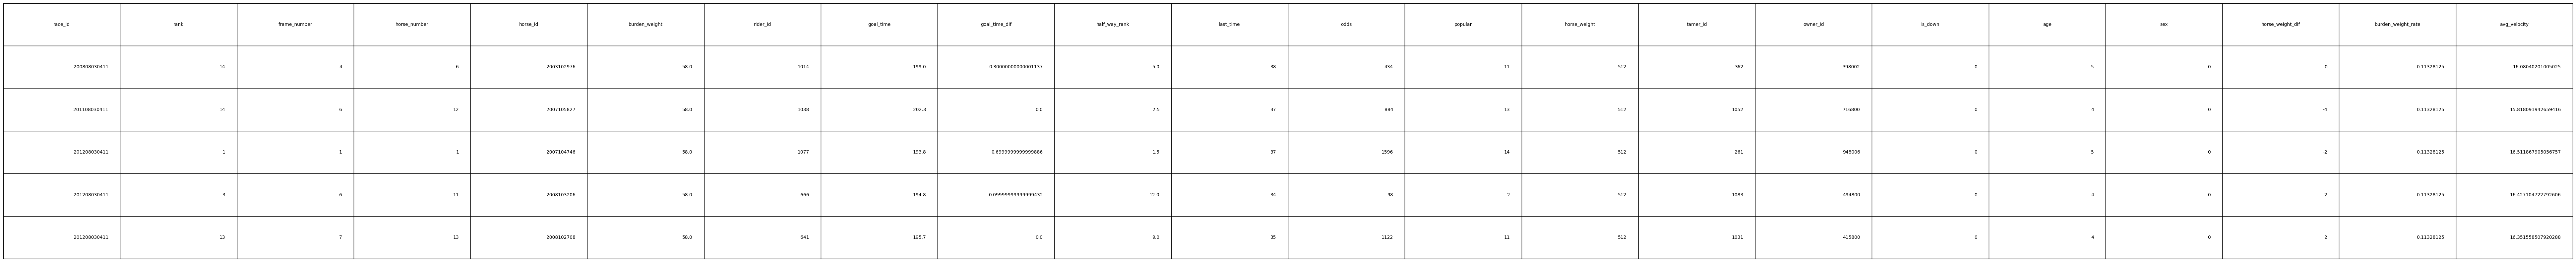

In [37]:
TablePlot(horse_df_head,100,10)

In [38]:
horse_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   race_id             265 non-null    Int64  
 1   rank                265 non-null    Int64  
 2   frame_number        265 non-null    Int64  
 3   horse_number        265 non-null    Int64  
 4   horse_id            265 non-null    Int64  
 5   burden_weight       265 non-null    float64
 6   rider_id            265 non-null    Int64  
 7   goal_time           265 non-null    float64
 8   goal_time_dif       265 non-null    float64
 9   half_way_rank       265 non-null    float64
 10  last_time           265 non-null    Int64  
 11  odds                265 non-null    Int64  
 12  popular             265 non-null    Int64  
 13  horse_weight        265 non-null    Int64  
 14  tamer_id            265 non-null    Int64  
 15  owner_id            265 non-null    Int64  
 16  is_down 

horse_dfには、レース時の競走馬の情報が入っている  
競走馬の順位を予測する上で、大事な情報である

### 各特徴量の説明

#### race_id

In [39]:
horse_df['race_id'].unique()

<IntegerArray>
[200808030411, 201108030411, 201208030411, 202008030411, 200608030411,
 201908030311, 202109021211, 200908030410, 201308030411, 201608030411,
 202209021211, 201008030410, 201408030411, 201708030411, 201508030411,
 201808030411, 200708030411]
Length: 17, dtype: Int64

過去に開催されたレースのIDが入っている  
年に一回開催されている  

#### rank

In [40]:
horse_df['rank'].unique()

<IntegerArray>
[14, 1, 3, 13, 6, 11, 17, 2, 8, 15, 12, 4, 7, 9, 16, 10, 5, 18]
Length: 18, dtype: Int64

各競走馬の順位が入っている  
今回の目的変数

#### frame_number

In [41]:
horse_df['frame_number'].unique()

<IntegerArray>
[4, 6, 1, 7, 5, 2, 8, 3]
Length: 8, dtype: Int64

各競走馬の枠番号が入っている

#### horse_number

In [42]:
horse_df['horse_number'].unique()

<IntegerArray>
[6, 12, 1, 11, 13, 8, 4, 9, 18, 5, 7, 10, 14, 3, 15, 17, 16, 2]
Length: 18, dtype: Int64

各競走馬の馬番が入っている

#### horse_id

In [43]:
horse_df['horse_id'].unique()

<IntegerArray>
[2003102976, 2007105827, 2007104746, 2008103206, 2008102708, 2014101976,
 1998105900, 2007103404, 2014101985, 2014100537,
 ...
 2004190006, 2006190010, 2008103192, 2008104467, 2011105057, 2000104060,
 2008103235, 2003105443, 2016104452, 2014106010]
Length: 186, dtype: Int64

各競走馬のIDが入っている

#### burden_weight

In [44]:
horse_df['burden_weight'].unique()

array([58., 56.])

In [45]:
horse_df['burden_weight'].value_counts()

58.0    253
56.0     12
Name: burden_weight, dtype: int64

牡馬の場合は57、牝馬は55である  
牝馬は過去2頭だけ出場している


#### rider_id

In [46]:
horse_df['rider_id'].unique()

<IntegerArray>
[1014, 1038, 1077,  666,  641, 1018, 1163, 1140, 1032, 5529, 1144,  422, 1085,
  663,  732,  700, 1115,  894,  660, 1093, 1031, 5386, 1127, 5212,  682, 5416,
 1088, 1116,  705, 5378, 1102, 1034, 5203, 5243, 1162, 1026, 1043,  945, 1119,
 1075, 1118, 1019, 1095, 1122, 1124, 1126, 5473, 5339,  643, 1029,  685, 1108,
  689, 1009,  711, 1025, 1130, 1112,  733,  712, 1092,  674,  709, 1170, 1174,
 1135,  865,  843, 1037, 1157, 1154]
Length: 71, dtype: Int64

騎手のIDが入っている

#### goal_time

In [47]:
horse_df['goal_time'].unique()

array([199. , 202.3, 193.8, 194.8, 195.7, 197.3, 196.2, 202. , 196.8,
       199.6, 194.7, 195.6, 194.4, 195.8, 198.1, 197.4, 198.8, 201.2,
       195.1, 195.2, 195.5, 196.9, 196. , 197.2, 194.9, 200.3, 203.2,
       197. , 204.9, 198.7, 196.6, 202.6, 197.5, 196.4, 197.6, 195.4,
       196.5, 196.1, 194.1, 200.7, 196.7, 192.5, 195.3, 200.9, 198.5,
       194.6, 201.3, 193.7, 198.9, 197.9, 194.5, 198.2, 198. , 194.2,
       195. , 195.9, 196.3, 200.2, 200. , 201.5, 203.4, 192.7, 194.3,
       201.7, 199.1, 201.1, 199.4, 202.2, 197.8, 197.1, 197.7, 193.6,
       201.9, 199.3, 193.5, 198.3, 194. , 193.3, 192.8, 200.6, 201.8,
       198.4, 198.6])

ゴールした時間が入ってる

#### goal_time_dif

In [48]:
horse_df['goal_time_dif'].unique()

array([ 0.3,  0. ,  0.7,  0.1,  0.2,  0.5,  1.1,  0.3,  1.2,  0.7,  0.2,
        0.4,  0.1,  0.6,  1.8,  0.8,  0.9,  0.4,  1. ,  0.8,  0.9,  3.6,
        1.9, -2.5,  2.1,  1.8,  1.5,  2.2,  1.2,  1.1,  6. ,  1.3,  6.5])

race_idでグループ化し、その差が入っている

#### half_way_rank

In [49]:
horse_df['half_way_rank'].unique()

array([ 5.  ,  2.5 ,  1.5 , 12.  ,  9.  ,  1.  ,  4.5 ,  5.5 ,  6.  ,
        3.5 , 10.5 , 15.75,  6.5 , 16.  , 16.5 ,  3.  ,  6.25,  1.25,
        7.  , 15.25,  2.75,  8.75, 13.75,  6.75, 10.25, 14.75,  9.5 ,
       12.25, 12.5 ,  5.25, 11.75,  8.5 , 10.75, 11.  ,  3.25, 14.  ,
       10.  , 13.  ,  9.75,  1.75,  2.  ,  4.25,  5.75,  9.25, 11.25,
        7.25,  7.5 , 17.25,  2.25, 13.5 ,  3.75, 13.25,  4.  ,  8.  ,
        4.75, 17.  , 14.25, 16.25,  7.75, 15.5 , 12.75, 17.75,  8.25,
       17.5 , 15.  , 11.5 , 18.  ])

各地点の順位の平均が入っている

#### last_time

In [50]:
horse_df['last_time'].unique()

<IntegerArray>
[38, 37, 34, 35, 36, 42, 39, 40, 41]
Length: 9, dtype: Int64

レース終盤のゴール手前から600mのタイムが入ってる

#### odds

In [51]:
horse_df['odds'].unique()

<IntegerArray>
[ 434,  884, 1596,   98, 1122,   53, 1800,   42,  542, 1539,
 ...
 1603, 2024,  393, 1774, 1286,  305, 2191,  872, 1421,  271]
Length: 233, dtype: Int64

各競走馬のオッズがはいっている

#### popular

In [52]:
horse_df['popular'].unique()

<IntegerArray>
[11, 13, 14, 2, 3, 10, 15, 5, 1, 4, 6, 16, 8, 12, 9, 17, 7, 18]
Length: 18, dtype: Int64

各競走馬のレース前人気度が入っている

#### horse_weight

In [53]:
horse_df['horse_weight'].unique()

<IntegerArray>
[512, 464, 426, 460, 498, 500, 510, 514, 482, 528, 458, 450, 446, 492, 438,
 516, 536, 524, 502, 470, 508, 504, 478, 456, 444, 488, 532, 506, 442, 422,
 476, 518, 468, 530, 526, 466, 534, 454, 484, 472, 520, 452, 494, 548, 462,
 486, 496, 480, 540, 432, 542, 490, 474, 448, 340, 342, 352, 434, 440]
Length: 59, dtype: Int64

各競走馬の場体重が入っている

#### tamer_id

In [54]:
horse_df['tamer_id'].unique()

<IntegerArray>
[ 362, 1052,  261, 1083, 1031, 1053,  253,  343, 1075, 1092,
 ...
 1154, 1168, 1029,  408, 1127,  422, 1033, 5658, 5559,  202]
Length: 104, dtype: Int64

各競走馬の調教師のIDが入っている

#### owner_id

In [55]:
horse_df['owner_id'].unique()

<IntegerArray>
[398002, 716800, 948006, 494800, 415800, 248030, 568800, 226800, 514008,
 677033,
 ...
   7803, 851009,  16008, 869006, 813030, 103033, 329004, 547800, 180800,
 266033]
Length: 108, dtype: Int64

各競走馬のオーナーのIDが入っている

#### is_down

In [56]:
horse_df['is_down'].unique()

<IntegerArray>
[0, 1]
Length: 2, dtype: Int64

In [57]:
horse_df['is_down'].value_counts()

0    264
1      1
Name: is_down, dtype: Int64

妨害を行ったせいで、順位が下がった場合1となる

#### age

In [58]:
horse_df['age'].unique()

<IntegerArray>
[5, 4, 6, 8, 7, 9, 10, 11]
Length: 8, dtype: Int64

すべて三歳馬なので削除

In [59]:
horse_df.drop('age', axis=1)

,race_id,rank,frame_number,horse_number,horse_id,burden_weight,rider_id,goal_time,goal_time_dif,half_way_rank,last_time,odds,popular,horse_weight,tamer_id,owner_id,is_down,sex,horse_weight_dif,burden_weight_rate,avg_velocity
0,200808030411,14,4,6,2003102976,58.0,1014,199.0,0.3,5.00,38,434,11,512,362,398002,0,0,0,0.113281,16.080402
1,201108030411,14,6,12,2007105827,58.0,1038,202.3,0.0,2.50,37,884,13,512,1052,716800,0,0,-4,0.113281,15.818092
2,201208030411,1,1,1,2007104746,58.0,1077,193.8,0.7,1.50,37,1596,14,512,261,948006,0,0,-2,0.113281,16.511868
3,201208030411,3,6,11,2008103206,58.0,666,194.8,0.1,12.00,34,98,2,512,1083,494800,0,0,-2,0.113281,16.427105
4,201208030411,13,7,13,2008102708,58.0,641,195.7,0.0,9.00,35,1122,11,512,1031,415800,0,0,2,0.113281,16.351559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,201008030410,5,1,2,2003105443,58.0,5203,197.2,0.4,7.25,35,687,12,440,1055,84800,0,2,-2,0.131818,16.227181
261,201708030411,10,3,5,2008104467,58.0,1115,193.8,0.3,8.00,36,2191,15,494,1095,486800,0,2,2,0.117409,16.511868
262,201408030411,14,3,5,2006190010,58.0,843,196.2,0.4,7.50,35,872,9,486,5559,103033,0,2,0,0.119342,16.309888
263,202109021211,12,5,10,2016104452,58.0,1157,197.5,0.6,10.75,39,1421,14,496,1154,266033,0,2,0,0.116935,16.202532


#### sex

In [60]:
horse_df['sex'].unique()

<IntegerArray>
[0, 1, 2]
Length: 3, dtype: Int64

In [61]:
horse_df['sex'].value_counts()

0    238
2     15
1     12
Name: sex, dtype: Int64

牝馬が2頭いる

#### horse_weight_dif

In [62]:
horse_df['horse_weight_dif'].unique()

<IntegerArray>
[0, -4, -2, 2, 6, -6, -10, -8, 4, 10, -14, 16, 8, -12]
Length: 14, dtype: Int64

前レースからの馬体重増減の数値が入ってる

#### burden_weight_rate

In [63]:
horse_df['burden_weight_rate'].unique()

array([0.11328125, 0.125     , 0.13615023, 0.12608696, 0.11646586,
       0.116     , 0.11372549, 0.11284047, 0.12033195, 0.10984848,
       0.12663755, 0.12888889, 0.13004484, 0.11788618, 0.13242009,
       0.1124031 , 0.10820896, 0.11068702, 0.11553785, 0.12340426,
       0.11417323, 0.11507937, 0.12133891, 0.12719298, 0.13063063,
       0.11885246, 0.10902256, 0.11462451, 0.13122172, 0.13744076,
       0.12184874, 0.11196911, 0.12393162, 0.10943396, 0.11026616,
       0.12446352, 0.10861423, 0.1277533 , 0.11983471, 0.12288136,
       0.11153846, 0.12831858, 0.11740891, 0.10583942, 0.12554113,
       0.11934156, 0.11693548, 0.12083333, 0.10740741, 0.13425926,
       0.10701107, 0.11836735, 0.12236287, 0.12280702, 0.12121212,
       0.11914894, 0.16470588, 0.11111111, 0.16374269, 0.15909091,
       0.12903226, 0.1124498 , 0.11666667, 0.13181818])

斤量を場体重で割ったものが入っている

#### avg_velocity

In [64]:
horse_df['avg_velocity'].unique()

array([16.08040201, 15.81809194, 16.51186791, 16.42710472, 16.35155851,
       16.2189559 , 16.30988787, 15.84158416, 16.2601626 , 16.03206413,
       16.43554186, 16.3599182 , 16.46090535, 16.34320735, 16.15345785,
       16.21073961, 16.09657948, 15.90457256, 16.40184521, 16.39344262,
       16.36828645, 16.25190452, 16.32653061, 16.22718053, 16.41867624,
       15.97603595, 15.7480315 , 16.24365482, 15.61737433, 16.10468042,
       16.27670397, 15.7946693 , 16.20253165, 16.29327902, 16.19433198,
       16.37666325, 16.28498728, 16.318205  , 16.48634724, 15.94419532,
       16.26842908, 16.62337662, 16.38504864, 15.92832255, 16.1209068 ,
       16.44398767, 15.89667163, 16.52039236, 16.08848668, 16.16978272,
       16.45244216, 16.14530777, 16.16161616, 16.47785788, 16.41025641,
       16.33486473, 16.30157922, 15.98401598, 16.        , 15.8808933 ,
       15.73254671, 16.60612351, 16.46937725, 15.86514626, 16.07232546,
       15.91248135, 16.04814443, 15.82591494, 16.17795753, 16.23

距離をゴール時間で割ったものが入っている

## horse_info_dfの探索

### 全体

In [65]:
pd.set_option('display.max_columns', 100)
horse_info_df_head = horse_info_df.head(5)
horse_info_df_head

,horse_id,bday,tamer_id,owner_id,producer_id,production_area,lifetime_record,wined_race_title,inbreeding_1,inbreeding_2,father,faths_father,faths_mother,mother,moths_father,moths_mother
0,1998105900,1998-03-21,05610,x0063a,910124.0,門別町,94戦13勝 [13-12-5-64],200205010111,1996102520,1.997106e+09,000a000082,000a0012cb,000a00877c,000a00005d,000a001607,000a00997a
1,2004110260,2004-09-30,01065,145006,650884.0,豪,39戦6勝 [6-4-6-23],201006030510,2005110208,NaN,000a00013a,000a001849,000a00a946,000a010c35,000a00185d,000a0089d1
2,2005106472,2005-03-30,01021,523005,400018.0,浦河町,35戦7勝 [7-3-6-19],201008050211,2007101803,2.004102e+09,000a00013a,000a001849,000a00a946,000a00679a,000a00185d,000a00a11d
3,2003102883,2003-03-01,01061,398002,370126.0,早来町,14戦7勝 [7-2-2-3],200808030411,2009106181,2.006103e+09,000a00013a,000a001849,000a00a946,1995107865,000a0002a6,000a0063be
4,2001103274,2001-03-13,01021,226800,343126.0,白老町,25戦5勝 [5-4-3-13],200608010711,2003102766,2.006103e+09,000a0001a7,000a001607,000a0091bb,1996106318,1981107017,1984104295


c:\Users\kawam\miniforge3\envs\keiba-django\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 38272 (\N{CJK UNIFIED IDEOGRAPH-9580}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\kawam\miniforge3\envs\keiba-django\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21029 (\N{CJK UNIFIED IDEOGRAPH-5225}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\kawam\miniforge3\envs\keiba-django\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30010 (\N{CJK UNIFIED IDEOGRAPH-753A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\kawam\miniforge3\envs\keiba-django\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25126 (\N{CJK UNIFIED IDEOGRAPH-6226}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\kawam\miniforge3\envs\keiba-django\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 212

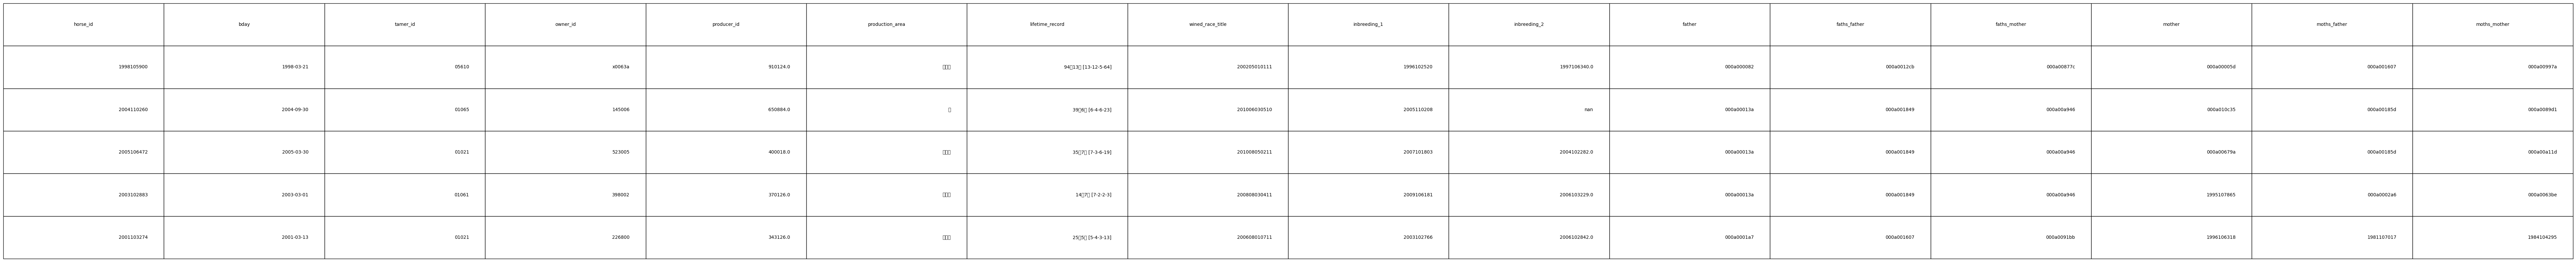

In [66]:
TablePlot(horse_info_df_head,100,10)

In [67]:
horse_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   horse_id          286 non-null    Int64  
 1   bday              286 non-null    dbdate 
 2   tamer_id          286 non-null    object 
 3   owner_id          286 non-null    object 
 4   producer_id       234 non-null    float64
 5   production_area   286 non-null    object 
 6   lifetime_record   286 non-null    object 
 7   wined_race_title  286 non-null    object 
 8   inbreeding_1      283 non-null    object 
 9   inbreeding_2      226 non-null    float64
 10  father            286 non-null    object 
 11  faths_father      286 non-null    object 
 12  faths_mother      286 non-null    object 
 13  mother            286 non-null    object 
 14  moths_father      286 non-null    object 
 15  moths_mother      286 non-null    object 
dtypes: Int64(1), dbdate(1), float64(2), object(1

競走馬の基本情報が入っている

### 各特徴量の説明

#### horse_id

In [68]:
horse_info_df['horse_id'].unique()

<IntegerArray>
[1998105900, 2004110260, 2005106472, 2003102883, 2001103274, 2000104060,
 2000105043, 2000105020, 2002100991, 2002100816,
 ...
 2017105649, 2016104946, 2018105293, 2016100915, 2015101077, 2014106160,
 2017105525, 2017102170, 2018103559, 2018106545]
Length: 203, dtype: Int64

各競走馬のIDが入っている

#### bday

In [69]:
horse_info_df['bday'].unique()

<DateArray>
[datetime.date(1998, 3, 21), datetime.date(2004, 9, 30),
 datetime.date(2005, 3, 30),  datetime.date(2003, 3, 1),
 datetime.date(2001, 3, 13), datetime.date(2000, 4, 17),
  datetime.date(2000, 5, 2),  datetime.date(2002, 4, 6),
 datetime.date(2002, 3, 25), datetime.date(2001, 2, 20),
 ...
 datetime.date(2017, 2, 12), datetime.date(2016, 3, 22),
 datetime.date(2018, 3, 18),  datetime.date(2016, 4, 7),
  datetime.date(2015, 4, 3), datetime.date(2014, 2, 26),
  datetime.date(2017, 4, 8), datetime.date(2017, 2, 18),
 datetime.date(2018, 2, 10),  datetime.date(2018, 3, 6)]
Length: 194, dtype: dbdate

各競走馬の生まれた日付けが入っている

#### tamer_id

In [70]:
horse_info_df['tamer_id'].unique()

array(['05610', '01065', '01021', '01061', '00202', '01029', '01098',
       '00343', '00110', '00383', '01002', '00399', '00362', '01082',
       '01019', '00216', '00415', '00406', '01055', '05105', '00348',
       '01058', '05559', '00339', '05762', '05658', '01158', '01041',
       '01016', '00369', '01119', '01009', '00422', '01042', '01046',
       '01093', '01049', '01108', '00375', '00119', '00340', '01053',
       '01014', '01071', '00434', '01107', '00429', '00138', '00419',
       '01123', '00411', '00301', '01105', '01031', '01054', '00408',
       '01163', '01038', 'a00ed', '00431', '01020', '01097', '01052',
       '01095', '01120', '00874', '01125', '01018', '01099', '01084',
       '01044', '00395', '01129', '01066', '01070', '00261', '01102',
       '01022', '05580', '01033', '05683', '01154', '01011', '00427',
       '05650', '01062', '00386', '01075', '01080', '01068', '01096',
       'a0366', '01083', '00420', '05388', '01110', '01027', '01160',
       '01104', '011

調教師のIDが入ってる

#### owner_id

In [71]:
horse_info_df['owner_id'].unique()

array(['x0063a', '145006', '523005', '398002', '226800', '547800',
       '663007', '695004', '708800', '084800', '372006', '246006',
       '415800', '656002', '270006', '356002', '716800', '603003',
       '103033', '318033', '302800', '813030', '231033', '006030',
       '712800', '574006', '703006', '537009', '635009', '790005',
       '539002', '506800', '057803', '515800', '758005', '769009',
       '542800', '261004', '768006', '494800', '307033', '764001',
       '430006', '546800', '078006', '831800', '872800', '306008',
       '882800', '794002', '098803', '553800', 'x00f2e', '965800',
       '763008', '260008', '561030', '970006', '966007', '180800',
       '287002', '731006', '582007', '138007', '948006', '151006',
       '143007', 'x07ee7', '131031', '675030', '370001', '441007',
       '169008', '297002', '124008', '234008', '419030', '808800',
       '869006', '788800', '016008', '019004', '075803', '399009',
       '334009', '266033', 'x0b0ba', '406030', '373800', '7378

オーナーのIDが入っている

#### producer_id

In [72]:
horse_info_df['producer_id'].unique()

array([9.10124e+05, 6.50884e+05, 4.00018e+05, 3.70126e+05, 3.43126e+05,
       1.40000e+01, 9.00314e+05, 4.00314e+05, 3.93126e+05, 2.30071e+05,
       9.40082e+05, 6.10012e+05, 2.00065e+05, 2.00096e+05,         nan,
       2.00091e+05, 5.10000e+05, 7.80880e+05, 3.73126e+05, 3.01513e+05,
       5.30396e+05, 4.00507e+05, 3.67000e+02, 6.10310e+05, 3.00126e+05,
       3.41000e+02, 1.33158e+05, 1.30158e+05, 1.00046e+05, 4.40033e+05,
       4.30333e+05, 4.30378e+05, 5.00315e+05, 1.07500e+03, 6.00016e+05,
       9.13344e+05, 3.19000e+02, 4.03394e+05, 5.00426e+05, 8.20102e+05,
       7.33393e+05, 4.33129e+05, 3.34680e+04, 3.03305e+05, 1.10021e+05,
       1.10014e+05, 4.10313e+05, 1.00328e+05, 7.33013e+05, 9.03088e+05,
       3.16000e+02, 2.03097e+05, 6.10030e+05, 8.30464e+05, 1.10300e+05,
       1.00383e+05, 8.00307e+05, 3.33050e+04, 3.33084e+05, 3.41126e+05,
       2.33360e+05, 1.00002e+05, 8.10464e+05, 6.00338e+05, 9.13124e+05,
       1.01328e+05, 4.00317e+05, 7.00335e+05, 8.00314e+05, 6.320

生産者のIDが入っている

#### production_area

In [73]:
horse_info_df['production_area'].unique()

array(['門別町', '豪', '浦河町', '早来町', '白老町', '新冠町', '千歳市', '静内町', '三石町',
       'ノーザンファーム', '三石', 'えりも町', '英', '愛', '仏', '安平町', '平取町', '白老ファーム',
       '新ひだか町', 'ビッグレッドファーム', '日高町', '社台コーポレーション白老ファーム', '追分ファーム',
       '新冠伊藤牧場', '社台ファーム', '木村秀則', '大樹町', '登別市', '様似町', 'ケイアイファーム',
       '洞爺湖町', '小泉学', 'レイクヴィラファーム', '青森県', 'コスモヴューファーム'], dtype=object)

In [74]:
horse_info_df['production_area'].value_counts()

安平町                 50
新冠町                 34
浦河町                 30
早来町                 26
ノーザンファーム            23
千歳市                 19
新ひだか町               19
日高町                 14
三石町                 13
静内町                  7
社台コーポレーション白老ファーム     6
門別町                  6
社台ファーム               5
ビッグレッドファーム           5
白老町                  3
平取町                  3
追分ファーム               2
小泉学                  2
洞爺湖町                 2
英                    2
ケイアイファーム             1
大樹町                  1
レイクヴィラファーム           1
様似町                  1
青森県                  1
登別市                  1
白老ファーム               1
木村秀則                 1
新冠伊藤牧場               1
豪                    1
仏                    1
愛                    1
えりも町                 1
三石                   1
コスモヴューファーム           1
Name: production_area, dtype: int64

生産地が入ってる  
今回は削除

In [75]:
horse_info_df.drop('production_area', axis=1)

,horse_id,bday,tamer_id,owner_id,producer_id,lifetime_record,wined_race_title,inbreeding_1,inbreeding_2,father,faths_father,faths_mother,mother,moths_father,moths_mother
0,1998105900,1998-03-21,05610,x0063a,910124.0,94戦13勝 [13-12-5-64],200205010111,1996102520,1.997106e+09,000a000082,000a0012cb,000a00877c,000a00005d,000a001607,000a00997a
1,2004110260,2004-09-30,01065,145006,650884.0,39戦6勝 [6-4-6-23],201006030510,2005110208,NaN,000a00013a,000a001849,000a00a946,000a010c35,000a00185d,000a0089d1
2,2005106472,2005-03-30,01021,523005,400018.0,35戦7勝 [7-3-6-19],201008050211,2007101803,2.004102e+09,000a00013a,000a001849,000a00a946,000a00679a,000a00185d,000a00a11d
3,2003102883,2003-03-01,01061,398002,370126.0,14戦7勝 [7-2-2-3],200808030411,2009106181,2.006103e+09,000a00013a,000a001849,000a00a946,1995107865,000a0002a6,000a0063be
4,2001103274,2001-03-13,01021,226800,343126.0,25戦5勝 [5-4-3-13],200608010711,2003102766,2.006103e+09,000a0001a7,000a001607,000a0091bb,1996106318,1981107017,1984104295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,2017105525,2017-04-08,01002,372006,373126.0,21戦4勝 [4-6-0-11],202106010811,2018105820,2.020104e+09,2010104155,1999110099,2002100844,2011103847,2002100816,1994108685
282,2017102170,2017-02-18,01058,041002,400317.0,21戦5勝 [5-4-1-11],202109011211,2015100894,2.019101e+09,2010105827,2002100816,000a00646f,2008105100,1995104427,1992109410
283,2017102170,2017-02-18,01058,041002,400317.0,21戦5勝 [5-4-1-11],202209011211,2015100894,2.019101e+09,2010105827,2002100816,000a00646f,2008105100,1995104427,1992109410
284,2018103559,2018-02-10,01127,518002,233071.0,15戦7勝 [7-2-0-6],202209021211,2016105526,NaN,2012104511,2001103460,2000107542,2008110046,000a010c91,000a0116ec


#### lifetime_record

In [76]:
horse_info_df['lifetime_record'].unique()

array(['94戦13勝 [13-12-5-64]', '39戦6勝 [6-4-6-23]', '35戦7勝 [7-3-6-19]',
       '14戦7勝 [7-2-2-3]', '25戦5勝 [5-4-3-13]', '26戦5勝 [5-3-2-16]',
       '62戦5勝 [5-3-8-46]', '45戦6勝 [6-10-4-25]', '22戦5勝 [5-4-2-11]',
       '14戦12勝 [12-1-0-1]', '37戦7勝 [7-10-5-15]', '23戦6勝 [6-5-3-9]',
       '27戦10勝 [10-2-1-14]', '22戦4勝 [4-3-2-13]', '30戦5勝 [5-7-5-13]',
       '38戦6勝 [6-5-3-24]', '27戦9勝 [9-7-2-9]', '44戦6勝 [6-6-5-27]',
       '42戦6勝 [6-7-3-26]', '1億4,406万円 (中央)', '48戦10勝 [10-8-1-29]',
       '46戦8勝 [8-9-7-22]', '22戦3勝 [3-4-3-12]', '35戦3勝 [3-8-6-18]',
       '16戦5勝 [5-2-3-6]', '27戦6勝 [6-3-7-11]', '48戦7勝 [7-7-0-34]',
       '6戦3勝 [3-2-0-1]', '24戦5勝 [5-4-3-12]', '28戦4勝 [4-5-3-16]',
       '13戦2勝 [2-2-0-9]', '23戦8勝 [8-4-2-9]', '47戦8勝 [8-3-0-36]',
       '31戦8勝 [8-10-2-11]', '34戦5勝 [5-6-2-21]', '18戦6勝 [6-3-2-7]',
       '37戦4勝 [4-1-1-31]', '23戦6勝 [6-2-2-13]', '48戦4勝 [4-6-4-34]',
       '39戦7勝 [7-3-2-27]', '54戦8勝 [8-1-6-39]', '43戦9勝 [9-4-6-24]',
       '36戦5勝 [5-5-5-21]', '40戦5勝 [5-6-2-27]', '29戦7勝 [7-6-2-1

獲得賞金が入っている  
フォーマットが統一されていないので、今回は削除

In [77]:
horse_info_df.drop('lifetime_record', axis=1)

,horse_id,bday,tamer_id,owner_id,producer_id,production_area,wined_race_title,inbreeding_1,inbreeding_2,father,faths_father,faths_mother,mother,moths_father,moths_mother
0,1998105900,1998-03-21,05610,x0063a,910124.0,門別町,200205010111,1996102520,1.997106e+09,000a000082,000a0012cb,000a00877c,000a00005d,000a001607,000a00997a
1,2004110260,2004-09-30,01065,145006,650884.0,豪,201006030510,2005110208,NaN,000a00013a,000a001849,000a00a946,000a010c35,000a00185d,000a0089d1
2,2005106472,2005-03-30,01021,523005,400018.0,浦河町,201008050211,2007101803,2.004102e+09,000a00013a,000a001849,000a00a946,000a00679a,000a00185d,000a00a11d
3,2003102883,2003-03-01,01061,398002,370126.0,早来町,200808030411,2009106181,2.006103e+09,000a00013a,000a001849,000a00a946,1995107865,000a0002a6,000a0063be
4,2001103274,2001-03-13,01021,226800,343126.0,白老町,200608010711,2003102766,2.006103e+09,000a0001a7,000a001607,000a0091bb,1996106318,1981107017,1984104295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,2017105525,2017-04-08,01002,372006,373126.0,安平町,202106010811,2018105820,2.020104e+09,2010104155,1999110099,2002100844,2011103847,2002100816,1994108685
282,2017102170,2017-02-18,01058,041002,400317.0,新冠町,202109011211,2015100894,2.019101e+09,2010105827,2002100816,000a00646f,2008105100,1995104427,1992109410
283,2017102170,2017-02-18,01058,041002,400317.0,新冠町,202209011211,2015100894,2.019101e+09,2010105827,2002100816,000a00646f,2008105100,1995104427,1992109410
284,2018103559,2018-02-10,01127,518002,233071.0,新ひだか町,202209021211,2016105526,NaN,2012104511,2001103460,2000107542,2008110046,000a010c91,000a0116ec


#### wined_race_titile

In [78]:
horse_info_df['wined_race_title'].unique()

array(['200205010111', '201006030510', '201008050211', '200808030411',
       '200608010711', '200704020311', '200341021307', '200609030610',
       '200707020311', '200605050810', '200806010811', '200508040211',
       '200706050809', '200605020311', '200409050310', '200605050211',
       '200605030410', '201006020211', '201009020410', '2009106351',
       '200406040411', '200808010611', '200608060209', '2012G0a01704',
       '201105010711', '201005030410', '201806050111', '2010A8a01706',
       '201605040310', '202106050111', '202009010509', '200408040211',
       '200509010811', '200709010811', '200805030412', '200609020510',
       '200509050211', '200708040711', '200306060111', '201305021212',
       '200706030111', '200408010611', '201305040110', '201308020411',
       '200704030611', '200803010211', '2003102720', '200208030511',
       '200605010611', '200408040611', '200505010611', '200906050111',
       '201609030611', '201409020610', '2003102816', '200604030710',
       '2007

In [79]:
horse_info_df['wined_race_title'].value_counts()

201009010811    8
201008030410    5
202009010911    4
2003100738      4
200709010811    3
               ..
201208040311    1
200806050111    1
200608010611    1
200706020509    1
202205010711    1
Name: wined_race_title, Length: 206, dtype: int64

代表的な優勝したレースのIDが入っている  
被っているレースがないので、今回は削除

In [80]:
horse_info_df.drop('wined_race_title', axis=1)

,horse_id,bday,tamer_id,owner_id,producer_id,production_area,lifetime_record,inbreeding_1,inbreeding_2,father,faths_father,faths_mother,mother,moths_father,moths_mother
0,1998105900,1998-03-21,05610,x0063a,910124.0,門別町,94戦13勝 [13-12-5-64],1996102520,1.997106e+09,000a000082,000a0012cb,000a00877c,000a00005d,000a001607,000a00997a
1,2004110260,2004-09-30,01065,145006,650884.0,豪,39戦6勝 [6-4-6-23],2005110208,NaN,000a00013a,000a001849,000a00a946,000a010c35,000a00185d,000a0089d1
2,2005106472,2005-03-30,01021,523005,400018.0,浦河町,35戦7勝 [7-3-6-19],2007101803,2.004102e+09,000a00013a,000a001849,000a00a946,000a00679a,000a00185d,000a00a11d
3,2003102883,2003-03-01,01061,398002,370126.0,早来町,14戦7勝 [7-2-2-3],2009106181,2.006103e+09,000a00013a,000a001849,000a00a946,1995107865,000a0002a6,000a0063be
4,2001103274,2001-03-13,01021,226800,343126.0,白老町,25戦5勝 [5-4-3-13],2003102766,2.006103e+09,000a0001a7,000a001607,000a0091bb,1996106318,1981107017,1984104295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,2017105525,2017-04-08,01002,372006,373126.0,安平町,21戦4勝 [4-6-0-11],2018105820,2.020104e+09,2010104155,1999110099,2002100844,2011103847,2002100816,1994108685
282,2017102170,2017-02-18,01058,041002,400317.0,新冠町,21戦5勝 [5-4-1-11],2015100894,2.019101e+09,2010105827,2002100816,000a00646f,2008105100,1995104427,1992109410
283,2017102170,2017-02-18,01058,041002,400317.0,新冠町,21戦5勝 [5-4-1-11],2015100894,2.019101e+09,2010105827,2002100816,000a00646f,2008105100,1995104427,1992109410
284,2018103559,2018-02-10,01127,518002,233071.0,新ひだか町,15戦7勝 [7-2-0-6],2016105526,NaN,2012104511,2001103460,2000107542,2008110046,000a010c91,000a0116ec


#### inbreeding_1

In [81]:
horse_info_df['inbreeding_1'].unique()

array(['1996102520', '2005110208', '2007101803', '2009106181',
       '2003102766', '2006102134', '2001107542', '1988101025',
       '1998101861', '2001103312', '2002100516', '2004102884',
       '2007100112', '2009106325', '2010103950', '2002104959',
       '2004102198', '2005104677', '2006103634', '201506030210',
       '2007103535', '2008103196', None, '000a013f63', '2009106005',
       '2002103090', '000a01521b', '2013105865', '2018100170',
       '2013106141', '2000101649', '2002106375', '2001103353',
       '2005105009', '2007106369', '2006104521', '2008102831',
       '2005102793', '2015104797', '1992103009', '2006104339',
       '2016102442', '2001107391', '2004103318', '2012101892',
       '200607030611', '1995104247', '1996107263', '1998101793',
       '1999106938', '2000107542', '2010105871', '2017103290',
       '200908010111', '2007102831', '2011104056', '200908030410',
       '2001100658', '2001105695', '2007102677', '2007103393',
       '2008104881', '2011100651', '20111

In [82]:
horse_info_df['inbreeding_1'].value_counts()

2007103697      8
2003107211      5
2017105582      4
200908030410    4
2003105299      3
               ..
2012101673      1
2014103551      1
2000102689      1
2001100508      1
2017106404      1
Name: inbreeding_1, Length: 201, dtype: int64

各競走馬の血統情報が入っている

#### inbreeding_2

In [83]:
horse_info_df['inbreeding_2'].unique()

array([1.99710634e+09,            nan, 2.00410228e+09, 2.00610323e+09,
       2.00610284e+09, 2.00810163e+09, 2.01010910e+09, 1.99710509e+09,
       2.00410307e+09, 2.01010404e+09, 2.00910574e+09, 2.00110334e+09,
       2.00110368e+09, 2.01610056e+09, 2.00010143e+09, 2.00610131e+09,
       2.00610223e+09, 2.00710400e+09, 2.00210117e+09, 2.00510416e+09,
       2.01210469e+09, 2.01310568e+09, 2.00810161e+09, 2.01910519e+09,
       2.01710435e+09, 2.01410621e+09, 2.01010151e+09, 2.00010644e+09,
       2.00610589e+09, 2.00910465e+09, 2.00010711e+09, 2.01010563e+09,
       2.00610293e+09, 2.00410522e+09, 2.01110388e+09, 2.00010516e+09,
       2.00310023e+09, 2.01110318e+09, 2.00510613e+09, 1.99810166e+09,
       2.00810317e+09, 1.99310945e+09, 2.00410690e+09, 2.00710326e+09,
       2.00610315e+09, 2.00710314e+09, 2.01610063e+09, 2.01610549e+09,
       2.00910586e+09, 2.00810332e+09, 2.00510640e+09, 2.00710519e+09,
       2.01310387e+09, 2.00910640e+09, 2.01010589e+09, 2.01510170e+09,
      

In [84]:
horse_info_df['inbreeding_2'].value_counts()

1.998110e+09    8
2.005107e+09    5
2.013106e+09    4
2.007103e+09    3
2.008102e+09    3
               ..
1.999107e+09    1
2.016104e+09    1
2.004102e+09    1
2.010106e+09    1
2.015103e+09    1
Name: inbreeding_2, Length: 158, dtype: int64

各競走馬の血統情報が入っている

#### father, faths_father, faths_mother, mother, moths_father, moths_mother

In [85]:
print('father'+str(horse_info_df['father'].unique()))
print('faths_father'+str(horse_info_df['faths_father'].unique()))
print('faths_mother'+str(horse_info_df['faths_mother'].unique()))
print('mother'+str(horse_info_df['mother'].unique()))
print('moths_father'+str(horse_info_df['moths_father'].unique()))
print('moths_mother'+str(horse_info_df['moths_mother'].unique()))

father['000a000082' '000a00013a' '000a0001a7' '000a0001d4' '000a0002a6'
 '000a00033a' '000a00035e' '000a000d77' '000a000d8c' '000a000d95'
 '000a000d99' '000a001e13' '000a0022d2' '000a00fa34' '000a0114fc'
 '000a011996' '000a011a7f' '000a012230' '1983109006' '1984101673'
 '1985103538' '1987107235' '1988101025' '1989109110' '1990109700'
 '1992102988' '1992103687' '1992109618' '1993109188' '1993190001'
 '1993190010' '1994108729' '1994109686' '1995103211' '1995104427'
 '1995107978' '1995108676' '1995108742' '1996107396' '1997105873'
 '1997106560' '1998101516' '1998101554' '1998101786' '1998103573'
 '1998110135' '1999100226' '1999104188' '1999106689' '1999106738'
 '1999107052' '1999110099' '2000101426' '2000101517' '2001103038'
 '2001103114' '2001103312' '2001103460' '2002100816' '2003102205'
 '2004102753' '2004103328' '2005101358' '2006102424' '2007103143'
 '2007105709' '2008102636' '2009102739' '2009105084' '2009106092'
 '2010104155' '2010105827' '2012104511' '2013105915']
faths_father['00

各競走馬の血統情報が入っている

## horse_race_dfの探索

### 全体

In [86]:
pd.set_option('display.max_columns', 100)
horse_race_df_head = horse_race_df.head(5)
horse_race_df_head

,date,where_racecourse,weather,race_round,race_title,race_id,total_horse_number,frame_number,horse_number,odds,popular,rank,rider_id,burden_weight,ground_status,goal_time,goal_time_dif,half_way_rank,pace,last_time,horse_weight,wined_horse_id,horse_id,target_race_id,race_rank,horse_weight_dif,is_down,burden_weight_rate,is_obstacle,ground_type,is_left_right_straight,distance,race_date
0,2016-05-28,5,2,11,欅S(OP),201605021111,16,1,1,380,9,7,1075,56.0,2,83.3,-0.3,9.5,35.50,36,472.0,2011104416,2010106467,201808030411,0,10.0,0,0.118644,0,1,0,1400,2018-04-29
1,2009-10-31,8,1,9,萩S(OP),200908040709,10,5,5,99,3,3,1014,55.0,1,107.2,1.4,5.5,35.15,36,486.0,2007110012,2007102951,201108030411,0,-2.0,0,0.113169,0,2,0,1800,2011-05-01
2,2008-11-01,8,1,9,萩S(OP),200808040709,6,6,6,24,1,5,666,55.0,1,108.6,0.3,6.0,35.15,35,494.0,2006102738,2006102061,201008030410,0,6.0,0,0.111336,0,2,0,1800,2010-05-02
3,2005-10-29,8,2,9,萩S(OP),200508040709,8,7,7,34,2,4,637,56.0,3,110.0,-0.1,3.0,35.50,35,496.0,2003102955,2003102205,200808030411,0,6.0,0,0.112903,0,2,0,1800,2008-05-04
4,2015-10-31,8,1,8,萩S(OP),201508040808,5,5,5,103,4,3,5203,55.0,1,107.8,-3.3,3.5,35.75,33,442.0,2013106118,2013106183,201808030411,0,-2.0,0,0.124434,0,2,0,1800,2018-04-29


c:\Users\kawam\miniforge3\envs\keiba-django\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 27397 (\N{CJK UNIFIED IDEOGRAPH-6B05}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\kawam\miniforge3\envs\keiba-django\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 33833 (\N{CJK UNIFIED IDEOGRAPH-8429}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


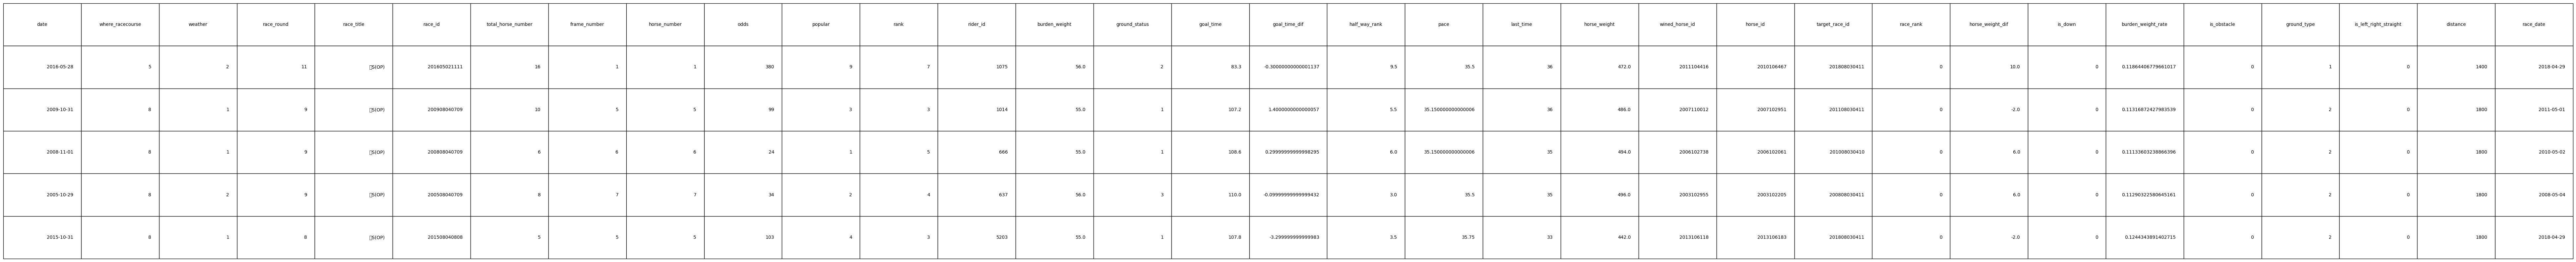

In [87]:
TablePlot(horse_race_df_head,100,10)

In [88]:
horse_race_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3592 entries, 0 to 3591
Data columns (total 33 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    3592 non-null   dbdate 
 1   where_racecourse        3592 non-null   Int64  
 2   weather                 3592 non-null   Int64  
 3   race_round              3592 non-null   Int64  
 4   race_title              3592 non-null   object 
 5   race_id                 3592 non-null   Int64  
 6   total_horse_number      3592 non-null   Int64  
 7   frame_number            3592 non-null   Int64  
 8   horse_number            3592 non-null   Int64  
 9   odds                    3592 non-null   Int64  
 10  popular                 3592 non-null   Int64  
 11  rank                    3592 non-null   Int64  
 12  rider_id                3592 non-null   Int64  
 13  burden_weight           3592 non-null   float64
 14  ground_status           3592 non-null   

競走馬の過去のレースが入っている

### 各特徴量の説明

#### date

In [89]:
horse_race_df['date'].unique()

<DateArray>
[ datetime.date(2016, 5, 28), datetime.date(2009, 10, 31),
  datetime.date(2008, 11, 1), datetime.date(2005, 10, 29),
 datetime.date(2015, 10, 31),  datetime.date(2012, 10, 7),
 datetime.date(2003, 11, 29), datetime.date(2010, 10, 30),
  datetime.date(2014, 9, 21), datetime.date(2015, 10, 17),
 ...
  datetime.date(2008, 4, 26),  datetime.date(2004, 4, 24),
  datetime.date(2017, 8, 26),  datetime.date(2018, 8, 26),
  datetime.date(2014, 4, 27),  datetime.date(2017, 8, 19),
  datetime.date(2015, 8, 22), datetime.date(2014, 12, 21),
 datetime.date(2011, 12, 18),  datetime.date(2020, 8, 22)]
Length: 1329, dtype: dbdate

レースの日付が入っている

#### where_racecourse

In [90]:
horse_race_df['where_racecourse'].unique()

<IntegerArray>
[5, 8, 9, 1, 6, 10, 2, 4, 7, 3, 0]
Length: 11, dtype: Int64

各レースの場所がラベリングされて入っている

#### weather

In [91]:
horse_race_df['weather'].unique()

<IntegerArray>
[2, 1, 3, 5, 6, 4]
Length: 6, dtype: Int64

各レースの天気がラベリングされて入っている

#### race_round

In [92]:
horse_race_df['race_round'].unique()

<IntegerArray>
[11, 9, 8, 6, 5, 4, 3, 7, 2, 10, 1, 12]
Length: 12, dtype: Int64

各レースの何ラウンド目に行われたかが入っている

#### race_title

In [93]:
horse_race_df['race_title'].unique()

array(['欅S(OP)', '萩S(OP)', '2歳新馬', '3歳新馬', '巴賞(OP)', '若葉S(L)', '万葉S(OP)',
       '丹頂S(OP)', '仁川S(OP)', '伏竜S(OP)', '六甲S(OP)', '富士S(G3)', '師走S(OP)',
       '平安S(G3)', '朱鷺S(OP)', '東海S(G2)', '栗東S(OP)', '洛陽S(OP)', '米子S(OP)',
       '芙蓉S(OP)', '若葉S(OP)', '若駒S(OP)', '阪神C(G2)', '阿蘇S(OP)', '霜月S(OP)',
       '2歳500万下', '2歳未勝利', '3歳500万下', '3歳未勝利', '七夕賞(G3)', '京成杯(G3)',
       '京阪杯(G3)', '大阪杯(G1)', '愛知杯(G3)', '日経賞(G2)', '毎日杯(G3)', '白百合S(L)',
       '皐月賞(G1)', '秋華賞(G1)', '菊花賞(G1)', '都大路S(L)', '金鯱賞(G2)', '阪急杯(G3)',
       'すみれS(OP)', 'エニフS(OP)', 'エルムS(G3)', 'オーロC(OP)', 'マーチS(G3)',
       '大阪城S(OP)', '春待月S(OP)', '白富士S(OP)', '白百合S(OP)', '都大路S(OP)',
       '野路菊S(OP)', '京都2歳S(OP)', '札幌2歳S(G3)', '中山記念(G2)', '京都記念(G2)',
       '優駿牝馬(G1)', '函館記念(G3)', '安田記念(G1)', '宝塚記念(G1)', '寿S(1600万下)',
       '小倉記念(G3)', '新潟記念(G3)', '有馬記念(G1)', '札幌記念(G2)', '東京優駿(G1)',
       '毎日王冠(G2)', '目黒記念(G2)', '福島記念(G3)', '関屋記念(G3)', '雅S(1600万下)',
       '鳴尾記念(G3)', 'NHKマイルC(G1)', 'いちょうS(OP)', 'しらかばS(OP)', 'アイビーS(OP)',
       'エプソ

レースのタイトルが入っている  
()内の文字をrace_rankに入れたので、こちらは削除

In [94]:
horse_race_df.drop('race_title',axis=1)

,date,where_racecourse,weather,race_round,race_id,total_horse_number,frame_number,horse_number,odds,popular,rank,rider_id,burden_weight,ground_status,goal_time,goal_time_dif,half_way_rank,pace,last_time,horse_weight,wined_horse_id,horse_id,target_race_id,race_rank,horse_weight_dif,is_down,burden_weight_rate,is_obstacle,ground_type,is_left_right_straight,distance,race_date
0,2016-05-28,5,2,11,201605021111,16,1,1,380,9,7,1075,56.0,2,83.3,-0.3,9.50,35.50,36,472.0,2011104416,2010106467,201808030411,0,10.0,0,0.118644,0,1,0,1400,2018-04-29
1,2009-10-31,8,1,9,200908040709,10,5,5,99,3,3,1014,55.0,1,107.2,1.4,5.50,35.15,36,486.0,2007110012,2007102951,201108030411,0,-2.0,0,0.113169,0,2,0,1800,2011-05-01
2,2008-11-01,8,1,9,200808040709,6,6,6,24,1,5,666,55.0,1,108.6,0.3,6.00,35.15,35,494.0,2006102738,2006102061,201008030410,0,6.0,0,0.111336,0,2,0,1800,2010-05-02
3,2005-10-29,8,2,9,200508040709,8,7,7,34,2,4,637,56.0,3,110.0,-0.1,3.00,35.50,35,496.0,2003102955,2003102205,200808030411,0,6.0,0,0.112903,0,2,0,1800,2008-05-04
4,2015-10-31,8,1,8,201508040808,5,5,5,103,4,3,5203,55.0,1,107.8,-3.3,3.50,35.75,33,442.0,2013106118,2013106183,201808030411,0,-2.0,0,0.124434,0,2,0,1800,2018-04-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3587,2014-12-21,7,1,11,201407040611,9,7,7,33,2,2,1138,55.0,3,138.2,0.0,1.00,36.75,37,498.0,2011101188,2011105057,201608030411,0,6.0,0,0.110442,0,2,0,2200,2016-05-01
3588,2012-12-15,7,2,10,201207030510,13,1,1,20,1,1,1122,57.0,2,135.6,0.1,9.25,35.70,35,482.0,2008102219,2008102064,201408030411,0,0.0,0,0.118257,0,2,0,2200,2014-05-04
3589,2011-12-18,10,2,10,201110050810,14,1,1,88,5,1,1018,55.0,1,159.8,-2.0,2.50,36.00,36,506.0,2008101281,2008104835,201408030411,0,-2.0,0,0.108696,0,2,0,2600,2014-05-04
3590,2020-08-22,1,1,11,202001020311,9,5,5,38,2,1,5339,55.0,1,160.0,0.0,3.25,36.65,36,502.0,2013105912,2016104452,202109021211,0,12.0,0,0.109562,0,2,0,2600,2021-05-02


#### race_id

In [95]:
horse_race_df['race_id'].unique()

<IntegerArray>
[201605021111, 200908040709, 200808040709, 200508040709, 201508040808,
 200808040706, 201208040205, 200308050704, 201008050706, 201409040405,
 ...
 201501020111, 200806010711, 201608040310, 201408040710, 201305021209,
 201407040611, 201207030510, 201110050810, 202001020311, 201901020111]
Length: 2073, dtype: Int64

レースのIDが入っている

#### total_horse_number

In [96]:
horse_race_df['total_horse_number'].unique()

<IntegerArray>
[16, 10, 6, 8, 5, 14, 7, 15, 12, 13, 11, 18, 9, 17]
Length: 14, dtype: Int64

何頭立てのレースかの情報が入っている

#### frame_number

In [97]:
horse_race_df['frame_number'].unique()

<IntegerArray>
[1, 5, 6, 7, 3, 8, 2, 4]
Length: 8, dtype: Int64

枠番が入っている

#### horse_number

In [98]:
horse_race_df['horse_number'].unique()

<IntegerArray>
[1, 5, 6, 7, 4, 13, 14, 11, 3, 10, 2, 9, 8, 16, 15, 18, 12, 17]
Length: 18, dtype: Int64

馬番が入っている

#### odds

In [99]:
horse_race_df['odds'].unique()

<IntegerArray>
[ 380,   99,   24,   34,  103,   65,   20,   69,   40,   63,
 ...
 1223,  571,  492, 2809,  857,  724, 1187,  839, 1067,  539]
Length: 673, dtype: Int64

オッズが入っている

#### popular

In [100]:
horse_race_df['popular'].unique()

<IntegerArray>
[9, 3, 1, 2, 4, 5, 11, 8, 14, 7, 10, 6, 16, 12, 13, 15, 17, 18]
Length: 18, dtype: Int64

人気順位が入っている

#### rank

In [101]:
horse_race_df['rank'].unique()

<IntegerArray>
[7, 3, 5, 4, 6, 1, 2, 9, 12, 10, 8, 11, 13, 15, 14, 18, 16, 17]
Length: 18, dtype: Int64

何着かが入っている

#### rider_id

In [102]:
horse_race_df['rider_id'].unique()

<IntegerArray>
[1075, 1014,  666,  637, 5203,  682, 1026, 5271,  422,  700,
 ...
 1134,  617, 1160, 5514,  140,  974, 5596, 5470, 1176, 5541]
Length: 167, dtype: Int64

騎手のIDが入っている

#### burden_weight

In [103]:
horse_race_df['burden_weight'].unique()

array([56. , 55. , 54. , 51. , 53. , 57. , 58. , 57.5, 50. , 52. , 59. ,
       58.5, 56.5, 62. , 49. ])

斤量の重さ（騎手の体重や馬具の重さを含む）が入っている  
不足するときは重りを使う

#### ground_status

In [104]:
horse_race_df['ground_status'].unique()

<IntegerArray>
[2, 1, 3, 5]
Length: 4, dtype: Int64

地面の状態がラベリングされて入っている

#### goal_time

In [105]:
horse_race_df['goal_time'].unique()

array([ 83.3, 107.2, 108.6, 110. , 107.8, 124.6, 111.6, 100.3, 125.6,
       124. , 114.1,  98.5, 110.9, 110.7, 112.6, 124.2, 123.8, 125.5,
       113.7, 114.5,  97.5,  97.8, 113.5, 111.1, 112.2, 123.7, 107.7,
        98.6, 100.1, 123.4, 111.7, 111.4, 112.8, 124.7, 111.9, 111.2,
        96.7, 111.8,  83.8, 109.9, 114.9,  69.9,  69.6,  70.4, 123.2,
       115.6,  71.7, 126.5, 109.3,  98.8,  97.4, 127.3,  82.4, 108. ,
        98.7, 110.4, 124.8,  85. ,  97.2, 114.8,  98.1, 111.3, 113.8,
       117.6,  70.2, 122.6, 123.5,  96.1, 127.7,  98.9,  93. , 110.8,
       126.1, 114.4, 125. , 127.2, 108.4, 111. , 103.7, 119.9, 117.4,
        88.2, 113.3,  95.9, 116.8, 117.8, 124.9, 119.8, 123.9, 128. ,
        75.9, 118.6,  96.8, 112.3,  75.2, 100.6, 125.4, 136.6, 126.3,
       108.1, 108.7, 122.9, 183.9, 184.5, 187.7, 187.6, 186.3, 186.2,
       188.5, 186.9, 189.5, 186.8, 187. , 186.4, 189. , 188.7, 188. ,
       190.3, 188.3, 187.3, 185.6, 185.7, 189.4, 189.1, 188.6, 164.2,
       161.1, 161.9,

ゴールタイムが入っている

#### goal_time_dif

In [106]:
horse_race_df['goal_time_dif'].unique()

array([ -0.3,   1.4,   0.3,  -0.1,  -3.3,   0.2,  -0.6,   1.5,  -2.9,
         0. ,  -0.4,   0.9,  -0.8,  -0.4,   0.1,  -2.4,   0.4,   1. ,
        -0.2,  -0.2,  -0.3,  -0.1,   0.5,  -1.8,  -0.2,  -0.3,  -4.5,
         0.6,   1.3,  -1.4,   3. ,  -1.2,   1.2,  -0.6,   0.8,   0.8,
        -1.3,  -1.1,   3.9,  -1.6,   0.4,   0.2,  -0.8,  -1.2,   0.3,
         2.3,  -0.7,   0.9,  -0.7,  -0.1,  -2.8,  -0.5,   0.7,   0.3,
         0.7,   0.4,  -1.5,   1.6,   2. ,  -4.2,  -0.9,  -2.1,  -1.6,
        -3.2,   1.9,   0.1,   2.1,  -0.8,   0.6,   2.2,   1.2,   1.1,
        -3.9,   2.9,   0.2,  -1.7,  -1. ,  -4.3,   1.8,   0.1,   0.6,
        -2.3,   2.5,   1.7,  -4.4,  -1.8,   1.6,   0.7,  -1.2,   1.3,
        -3.6,  -3.1,  -0.9,  -3.7,   1.7,   1.9,  -3.4,  -1.9,   1.4,
         1.1,   1.8,  -7.5,  -2.7,   2.7,  -0.4,   2.1,  -2.6,  -1.9,
        -2. ,  -1.7,  -1.1,  -1.3,   0.8,   2.6,  -2.2,   2.2,   3.5,
        -5.5,   7.5,   2.4,   6.6,  -3.8,   1.2,  -1.8,   6.8,   5.7,
        -0.6,   2.8,

ゴールタイムの差が入っている

#### half_way_rank

In [107]:
horse_race_df['half_way_rank'].unique()

array([ 9.5       ,  5.5       ,  6.        ,  3.        ,  3.5       ,
        7.5       ,  4.        , 10.5       , 10.        ,  5.75      ,
        9.        ,  2.25      ,  1.25      ,  8.75      , 12.75      ,
       11.        ,  5.        ,  8.        ,  6.25      , 10.25      ,
        4.5       ,  7.        , 11.25      ,  1.66666667,  6.5       ,
        2.33333333,  2.        ,  1.75      ,  3.75      ,  1.        ,
        2.5       ,  5.25      , 13.5       , 12.        ,  9.25      ,
        8.5       ,  5.66666667,  4.75      , 10.33333333, 16.5       ,
       13.33333333,  6.33333333,  9.33333333, 15.        ,  3.33333333,
       13.        ,  2.75      ,  9.66666667, 12.5       , 11.5       ,
        8.25      ,  3.25      ,  7.75      ,  6.75      , 17.5       ,
       14.5       ,  5.33333333,  9.75      ,  7.25      ,  4.25      ,
       14.        ,  7.66666667, 17.        ,  8.66666667,  4.66666667,
       12.66666667,  7.33333333, 13.25      , 10.66666667, 11.33

各地点の馬の順位の平均値が入っている

#### pace

In [108]:
horse_race_df['pace'].unique()

array([35.5 , 35.15, 35.75, 36.25, 37.  , 35.85, 36.2 , 36.7 , 35.85,
       36.05, 35.6 , 36.8 , 35.9 , 36.55, 35.25, 37.3 , 36.35, 36.15,
       35.8 , 36.6 , 37.1 , 36.85, 35.15, 36.15, 35.95, 36.4 , 37.55,
       36.9 , 35.7 , 37.2 , 36.5 , 37.15, 34.85, 37.15, 34.8 , 36.1 ,
       36.35, 36.65, 35.1 , 35.6 , 36.75, 35.3 , 35.45, 36.  , 36.65,
       38.05, 35.65, 35.4 , 38.5 , 34.9 , 36.45, 33.3 , 37.5 , 36.95,
       38.9 , 37.6 , 38.65, 38.85, 36.3 , 36.1 , 38.8 , 36.85, 37.45,
       38.1 , 35.9 , 37.4 , 35.55, 35.65, 37.35, 37.05, 36.4 , 37.9 ,
       35.35, 35.35, 34.7 , 34.5 , 35.  , 34.65, 32.9 , 35.2 , 34.4 ,
       35.4 , 33.8 , 35.1 , 37.1 , 33.25, 37.65, 35.05, 33.95, 37.25,
       36.9 , 37.7 , 37.95, 33.15, 38.4 , 37.9 , 34.95, 39.55, 34.6 ,
       32.35, 38.65, 37.8 , 34.75, 33.4 , 37.65, 37.75, 37.35, 34.35,
       33.85, 37.6 , 34.65, 33.9 , 34.1 , 38.25, 32.45, 33.  , 33.1 ,
       32.75, 32.95, 33.2 , 33.35, 33.5 , 32.4 , 33.4 , 33.65, 32.8 ,
       38.9 , 34.6 ,

前半3ハロンと後半3ハロンを一位通過した馬のタイムの平均値

#### last_time

In [109]:
horse_race_df['last_time'].unique()

<IntegerArray>
[36, 35, 33, 34, 37, 42, 38, 39, 40, 41, 43, 44, 45]
Length: 13, dtype: Int64

上りのタイムが入っている

#### horse_weight

In [110]:
horse_race_df['horse_weight'].unique()

array([472., 486., 494., 496., 442., 492., 482., 518., 464., 476., 500.,
       470., 454., 478., 502., 446., 526., 468., 436., 508., 506., 448.,
       426., 432., 484., 504., 520., 488., 498., 452., 516., 466., 474.,
       456., 480., 458., 440., 460., 336., 510., 530., 522., 430., 490.,
       548., 514., 532., 556., 462., 416., 450., 438., 444., 340., 512.,
       342., 414., 338., 330., 428., 420., 540., 524., 546., 534., 410.,
       412., 538., 550., 424., 536., 542., 434., 422., 528., 554., 544.,
       483., 497., 348., 552., 521.])

馬体重が入っている

#### wined_horse_id

In [111]:
horse_race_df['wined_horse_id'].unique()

<IntegerArray>
[2011104416, 2007110012, 2006102738, 2003102955, 2013106118, 2006102974,
 2010103695, 2001106211, 2008101745, 2012104327,
 ...
 2001104804, 2008101228, 2008105612, 2013101447, 2003103797, 2012104733,
 2010104256, 2010103747, 2008102219, 2016110024]
Length: 1622, dtype: Int64

1着（1着の場合は2着）の馬のIDが入っている

#### horse_id

In [112]:
horse_race_df['horse_id'].unique()

<IntegerArray>
[2010106467, 2007102951, 2006102061, 2003102205, 2013106183, 2006103169,
 2010105827, 2001103389, 2008103095, 2012104759,
 ...
 2012104614, 2009106351, 2013103569, 2006190010, 1999107049, 2002100677,
 2008101521, 2006101762, 2000105043, 2015104649]
Length: 181, dtype: Int64

競走馬のIDが入っている

#### race_rank

In [113]:
horse_race_df['race_rank'].unique()

<IntegerArray>
[0, 1, 2, 3]
Length: 4, dtype: Int64

レースのランクがラベリングされて入っている  
G1は3である

#### horse_weight_dif

In [114]:
horse_race_df['horse_weight_dif'].unique()

array([ 10.,  -2.,   6.,   0.,   2.,  -6., -12.,  -4.,   4.,  12.,  18.,
        14.,   8.,  -8., -10., -14., -16., -18.,  20., -26., -22.,  30.,
        16.,  22.,  -1.,  -7.,  -3.,  24.,   3., -11., -24.,   1.,  26.,
        -5.])

全レースとの体重の差が入っている

#### is_down

In [115]:
horse_race_df['is_down'].unique()

<IntegerArray>
[0, 1]
Length: 2, dtype: Int64

違反などをして、順位が降格したかが入っている

#### burden_weight_rate

In [116]:
horse_race_df['burden_weight_rate'].unique()

array([0.11864407, 0.11316872, 0.11133603, 0.11290323, 0.12443439,
       0.11178862, 0.11410788, 0.10617761, 0.11853448, 0.11637931,
       0.11554622, 0.11      , 0.11702128, 0.11894273, 0.11506276,
       0.10956175, 0.11344538, 0.1097561 , 0.12107623, 0.1026616 ,
       0.11752137, 0.11489362, 0.11697248, 0.10629921, 0.11652542,
       0.10869565, 0.12053571, 0.11440678, 0.12676056, 0.10931174,
       0.125     , 0.11363636, 0.10714286, 0.10826772, 0.10756972,
       0.1090535 , 0.10384615, 0.11065574, 0.1199095 , 0.1120332 ,
       0.11297071, 0.11044177, 0.11946903, 0.12114537, 0.10887097,
       0.10465116, 0.11587983, 0.11111111, 0.11270492, 0.11392405,
       0.11842105, 0.11458333, 0.12008734, 0.12045455, 0.1173913 ,
       0.15178571, 0.11790393, 0.12168142, 0.12061404, 0.10784314,
       0.10671937, 0.1108871 , 0.11603376, 0.10843373, 0.10566038,
       0.11067194, 0.10646388, 0.10810811, 0.11155378, 0.11666667,
       0.1147541 , 0.10727969, 0.10852713, 0.11023622, 0.10769

斤量を場体重で割ったものが入っている

#### is_obstacle

In [117]:
horse_race_df['is_obstacle'].unique()

<IntegerArray>
[0]
Length: 1, dtype: Int64

障害レースの場合は1が入っている

#### ground_type

In [118]:
horse_race_df['ground_type'].unique()

<IntegerArray>
[1, 2]
Length: 2, dtype: Int64

芝やダービーなどの情報が入っている

#### is_left_right_straight

In [119]:
horse_race_df['is_left_right_straight'].unique()

<IntegerArray>
[0]
Length: 1, dtype: Int64

右回りや左周りなどの情報が入っている

#### distance

In [120]:
horse_race_df['distance'].unique()

<IntegerArray>
[1400, 1800, 2000, 1600, 1700, 1200, 1500, 2200, 3000, 2600, 1900, 2500, 2400,
 1300, 2300, 3200, 2100, 3600, 3400]
Length: 19, dtype: Int64

レースの距離が入っている

#### race_date

In [121]:
horse_race_df['race_date'].unique()

<DateArray>
[datetime.date(2018, 4, 29),  datetime.date(2011, 5, 1),
  datetime.date(2010, 5, 2),  datetime.date(2008, 5, 4),
 datetime.date(2012, 4, 29),  datetime.date(2014, 5, 4),
  datetime.date(2015, 5, 3), datetime.date(2007, 4, 29),
  datetime.date(2009, 5, 3), datetime.date(2013, 4, 28),
  datetime.date(2016, 5, 1),  datetime.date(2020, 5, 3),
 datetime.date(2017, 4, 30), datetime.date(2019, 4, 28),
  datetime.date(2022, 5, 1),  datetime.date(2021, 5, 2),
 datetime.date(2006, 4, 30)]
Length: 17, dtype: dbdate

レースの日付の情報が入っている

### 各特徴量の探索

#### データのマージ

In [122]:

horse_df_tmp = horse_df[['horse_id','rank']]
horse_race_df_marged = pd.DataFrame()
horse_race_df_marged = pd.merge(horse_df_tmp, horse_race_df, on='horse_id', how='inner', suffixes=('_y', '_x'))

In [123]:
horse_race_df_marged

,horse_id,rank_y,date,where_racecourse,weather,race_round,race_title,race_id,total_horse_number,frame_number,horse_number,odds,popular,rank_x,rider_id,burden_weight,ground_status,goal_time,goal_time_dif,half_way_rank,pace,last_time,horse_weight,wined_horse_id,target_race_id,race_rank,horse_weight_dif,is_down,burden_weight_rate,is_obstacle,ground_type,is_left_right_straight,distance,race_date
0,2003102976,14,2006-10-22,8,1,11,菊花賞(G1),200608050611,18,3,5,62,3,3,666,57.0,1,183.0,-3.4,1.00,35.50,36,498.0,2003102461,200808030411,3,8.0,0,0.114458,0,2,0,3000,2008-05-04
1,2003102976,14,2007-05-26,7,1,11,金鯱賞(G2),200707020311,12,8,11,42,2,10,1014,57.0,1,118.3,2.2,2.00,34.95,37,504.0,2002100991,200808030411,2,8.0,0,0.113095,0,2,0,2000,2008-05-04
2,2003102976,14,2007-06-24,9,3,11,宝塚記念(G1),200709030411,18,5,10,582,12,17,1088,58.0,2,138.2,1.1,4.25,35.20,42,502.0,2003102991,200808030411,3,-2.0,0,0.115538,0,2,0,2200,2008-05-04
3,2003102976,14,2006-12-24,6,1,9,有馬記念(G1),200606050809,14,6,10,354,7,9,641,55.0,1,152.8,0.3,1.00,32.70,36,496.0,2002100816,200808030411,3,-7.0,0,0.110887,0,2,0,2500,2008-05-04
4,2003102976,14,2007-12-15,6,1,11,ディセンバーS(OP),200706050511,16,4,7,37,2,4,1088,57.0,1,108.0,-0.7,1.75,36.30,38,508.0,2003102527,200808030411,0,6.0,0,0.112205,0,2,0,1800,2008-05-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7783,2016104452,12,2020-01-25,8,2,9,睦月賞(2勝クラス),202008010809,10,7,7,32,2,5,5531,55.0,2,149.7,0.0,3.00,35.55,37,506.0,2011103632,202109021211,0,4.0,0,0.108696,0,2,0,2400,2021-05-02
7784,2016104452,12,2020-03-15,9,3,9,淡路特別(2勝クラス),202009010609,11,6,6,38,3,7,1126,55.0,2,160.9,0.0,5.75,35.45,37,510.0,2016102045,202109021211,0,4.0,0,0.107843,0,2,0,2600,2021-05-02
7785,2016104452,12,2020-07-12,2,2,10,横津岳特別(2勝クラス),202002020410,13,2,2,134,6,7,1163,57.0,1,163.4,0.0,4.75,36.45,36,494.0,2017101695,202109021211,0,-16.0,0,0.115385,0,2,0,2600,2021-05-02
7786,2016104452,12,2020-08-01,1,1,10,阿寒湖特別(2勝クラス),202001010310,10,7,8,88,4,2,5203,57.0,1,160.3,0.0,5.50,36.70,36,490.0,2017105000,202109021211,0,-4.0,0,0.116327,0,2,0,2600,2021-05-02


In [124]:
horse_df['horse_id'].nunique()

186

In [125]:
horse_race_df['horse_id'].nunique()

181

In [126]:
# import seaborn as sns
# sns.set(rc={'figure.figsize':(30,20)})
# sns.set(style="white")
# corr = horse_race_df_marged.corr()
# mask = np.zeros_like(corr, dtype=bool)
# mask[np.triu_indices_from(mask)] = True
# sns.heatmap(data = corr, mask = mask, linewidth = 0.5, annot = True)

In [127]:
#id系やいらないカラムを削除
horse_race_df_marged_droped = horse_race_df_marged.drop(['horse_id', 
                                                          'race_id',
                                                          'rider_id',
                                                          'wined_horse_id',
                                                          'target_race_id',
                                                          'is_down',
                                                          'is_obstacle',
                                                          'is_left_right_straight'],
                                                          axis=1
                                                          )

In [128]:
# sns.set(rc={'figure.figsize':(30,20)})
# sns.set(style="white")
# corr = horse_race_df_marged_droped.corr()
# mask = np.zeros_like(corr, dtype=bool)
# mask[np.triu_indices_from(mask)] = True
# sns.heatmap(data = corr, mask = mask, linewidth = 0.5, annot = True)

In [129]:
# #G1だけで見てみる
# import seaborn as sns
# sns.set(rc={'figure.figsize':(30,20)})
# sns.set(style="white")
# corr = horse_race_df_marged_droped[horse_race_df_marged_droped['race_rank']==3].corr()
# mask = np.zeros_like(corr, dtype=bool)
# mask[np.triu_indices_from(mask)] = True
# sns.heatmap(data = corr, mask = mask, linewidth = 0.5, annot = True)

In [130]:
#G1だけだと、相関が上がる
horse_race_df_marged_droped_g1 = horse_race_df_marged_droped[horse_race_df_marged_droped['race_rank']==3]
horse_race_df_marged_droped_g1 = horse_race_df_marged_droped_g1.drop(['burden_weight','race_rank'],axis=1)

In [131]:
# #G1だけで見てみる
# import seaborn as sns
# sns.set(rc={'figure.figsize':(30,20)})
# sns.set(style="white")
# corr = horse_race_df_marged_droped_g1.corr()
# mask = np.zeros_like(corr, dtype=bool)
# mask[np.triu_indices_from(mask)] = True
# sns.heatmap(data = corr, mask = mask, linewidth = 0.5, annot = True)

In [132]:
horse_race_df_marged['date']

0       2006-10-22
1       2007-05-26
2       2007-06-24
3       2006-12-24
4       2007-12-15
           ...    
7783    2020-01-25
7784    2020-03-15
7785    2020-07-12
7786    2020-08-01
7787    2020-08-22
Name: date, Length: 7788, dtype: dbdate

In [133]:
df_latest_race = horse_race_df_marged.groupby('horse_id').apply(lambda x: x[x['date'] == x['date'].max()])
df_latest_race = df_latest_race.reset_index(drop=True)

In [134]:
df_latest_race = df_latest_race.drop([#'horse_id', 
                                                          'race_id',
                                                          'rider_id',
                                                          'wined_horse_id',
                                                          'target_race_id',
                                                          'is_down',
                                                          'is_obstacle',
                                                          'is_left_right_straight'],
                                                          axis=1
                                                          )

In [135]:
# #最新のレースだけで見てみる
# import seaborn as sns
# sns.set(rc={'figure.figsize':(30,20)})
# sns.set(style="white")
# corr = df_latest_race.corr()
# mask = np.zeros_like(corr, dtype=bool)
# mask[np.triu_indices_from(mask)] = True
# sns.heatmap(data = corr, mask = mask, linewidth = 0.5, annot = True)

In [136]:
df_latest_race = df_latest_race.drop('date',axis=1)
df_latest_race = df_latest_race.drop('race_title',axis=1)
df_latest_race = df_latest_race.drop('race_date',axis=1)

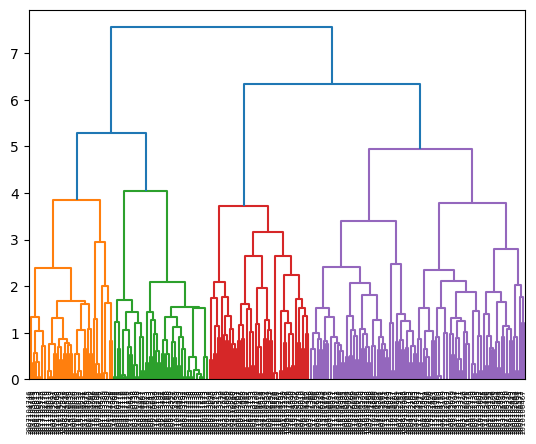

In [137]:
#スケーリング
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
column = df_latest_race["horse_id"].values
X = df_latest_race.drop('horse_id', axis=1).values
scaler.fit(X) 
X_scaled = scaler.transform(X)
# 凝集型階層クラスタリングの計算と結果
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

result = linkage(X_scaled, method = "ward")
dendrogram(result, labels = column)
plt.show()

In [138]:
# クラスターの計算
from scipy.cluster.hierarchy import fcluster
cluster = fcluster(result, t = 5, criterion = "distance")
cluster

array([4, 4, 4, 3, 3, 1, 1, 3, 4, 2, 2, 2, 1, 1, 1, 2, 4, 3, 4, 4, 3, 4,
       4, 4, 4, 4, 1, 1, 1, 3, 3, 1, 3, 1, 4, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 3, 4, 3, 4, 3, 4, 3, 3, 4, 4, 4, 2, 2, 3, 3, 2, 2, 4, 4,
       4, 4, 3, 2, 2, 2, 2, 3, 1, 1, 1, 1, 3, 3, 3, 4, 3, 3, 1, 3, 2, 2,
       2, 2, 2, 4, 3, 4, 3, 3, 3, 2, 4, 4, 4, 4, 4, 4, 1, 1, 1, 2, 1, 4,
       4, 4, 4, 3, 4, 4, 4, 3, 4, 2, 4, 4, 4, 4, 3, 3, 4, 2, 2, 2, 4, 4,
       4, 4, 2, 2, 4, 1, 4, 4, 4, 4, 4, 1, 4, 3, 4, 4, 4, 4, 4, 4, 3, 4,
       1, 1, 1, 1, 2, 2, 4, 4, 4, 4, 4, 1, 2, 3, 1, 1, 1, 4, 4, 1, 3, 1,
       4, 4, 4, 4, 4, 2, 4, 4, 2, 4, 4, 3, 1, 4, 3, 3, 4, 4, 4, 4, 2, 4,
       4, 4, 1, 4, 4, 4, 4, 3, 4, 4, 4, 4, 2, 2, 4, 4, 1, 3, 4, 2, 4, 4,
       3, 4, 4, 1, 1, 1, 1, 4, 4, 4, 4, 2, 2, 3, 3, 3, 3, 3, 4, 3, 3, 3,
       4, 1, 1, 3, 1, 2], dtype=int32)

In [139]:
data = df_latest_race.assign(cluster = cluster)
data["cluster"] = data["cluster"].astype("str")    # cluster列を数値から文字列にcast

In [140]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   horse_id            248 non-null    Int64  
 1   rank_y              248 non-null    Int64  
 2   where_racecourse    248 non-null    Int64  
 3   weather             248 non-null    Int64  
 4   race_round          248 non-null    Int64  
 5   total_horse_number  248 non-null    Int64  
 6   frame_number        248 non-null    Int64  
 7   horse_number        248 non-null    Int64  
 8   odds                248 non-null    Int64  
 9   popular             248 non-null    Int64  
 10  rank_x              248 non-null    Int64  
 11  burden_weight       248 non-null    float64
 12  ground_status       248 non-null    Int64  
 13  goal_time           248 non-null    float64
 14  goal_time_dif       248 non-null    float64
 15  half_way_rank       248 non-null    float64
 16  pace    

In [141]:
data = data.drop(['horse_id', 'goal_time'], axis=1)

In [142]:
# sns.pairplot(data, hue="cluster", diag_kind='hist',corner=True)
# plt.show()

In [157]:
race_df_tmp = race_df.drop(['race_id',
                        "race_rank", 
                        "is_obstacle",
                        "ground_type", 
                        "is_left_right_straight",
                        "distance",
                        "tansyo",
                        "hukusyo_first",
                        "hukusyo_second",
                        "hukusyo_third",
                        "wakuren",
                        "umaren",
                        "wide_1_2",
                        "wide_1_3",
                        "wide_2_3",
                        "umatan",
                        #"renhuku3",
                        #"rentan3",	
                        
                        
                        
                        ], axis=1)

C:\Users\kawam\AppData\Local\Temp\ipykernel_7460\3699697583.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = race_df_tmp.corr()


<Axes: >

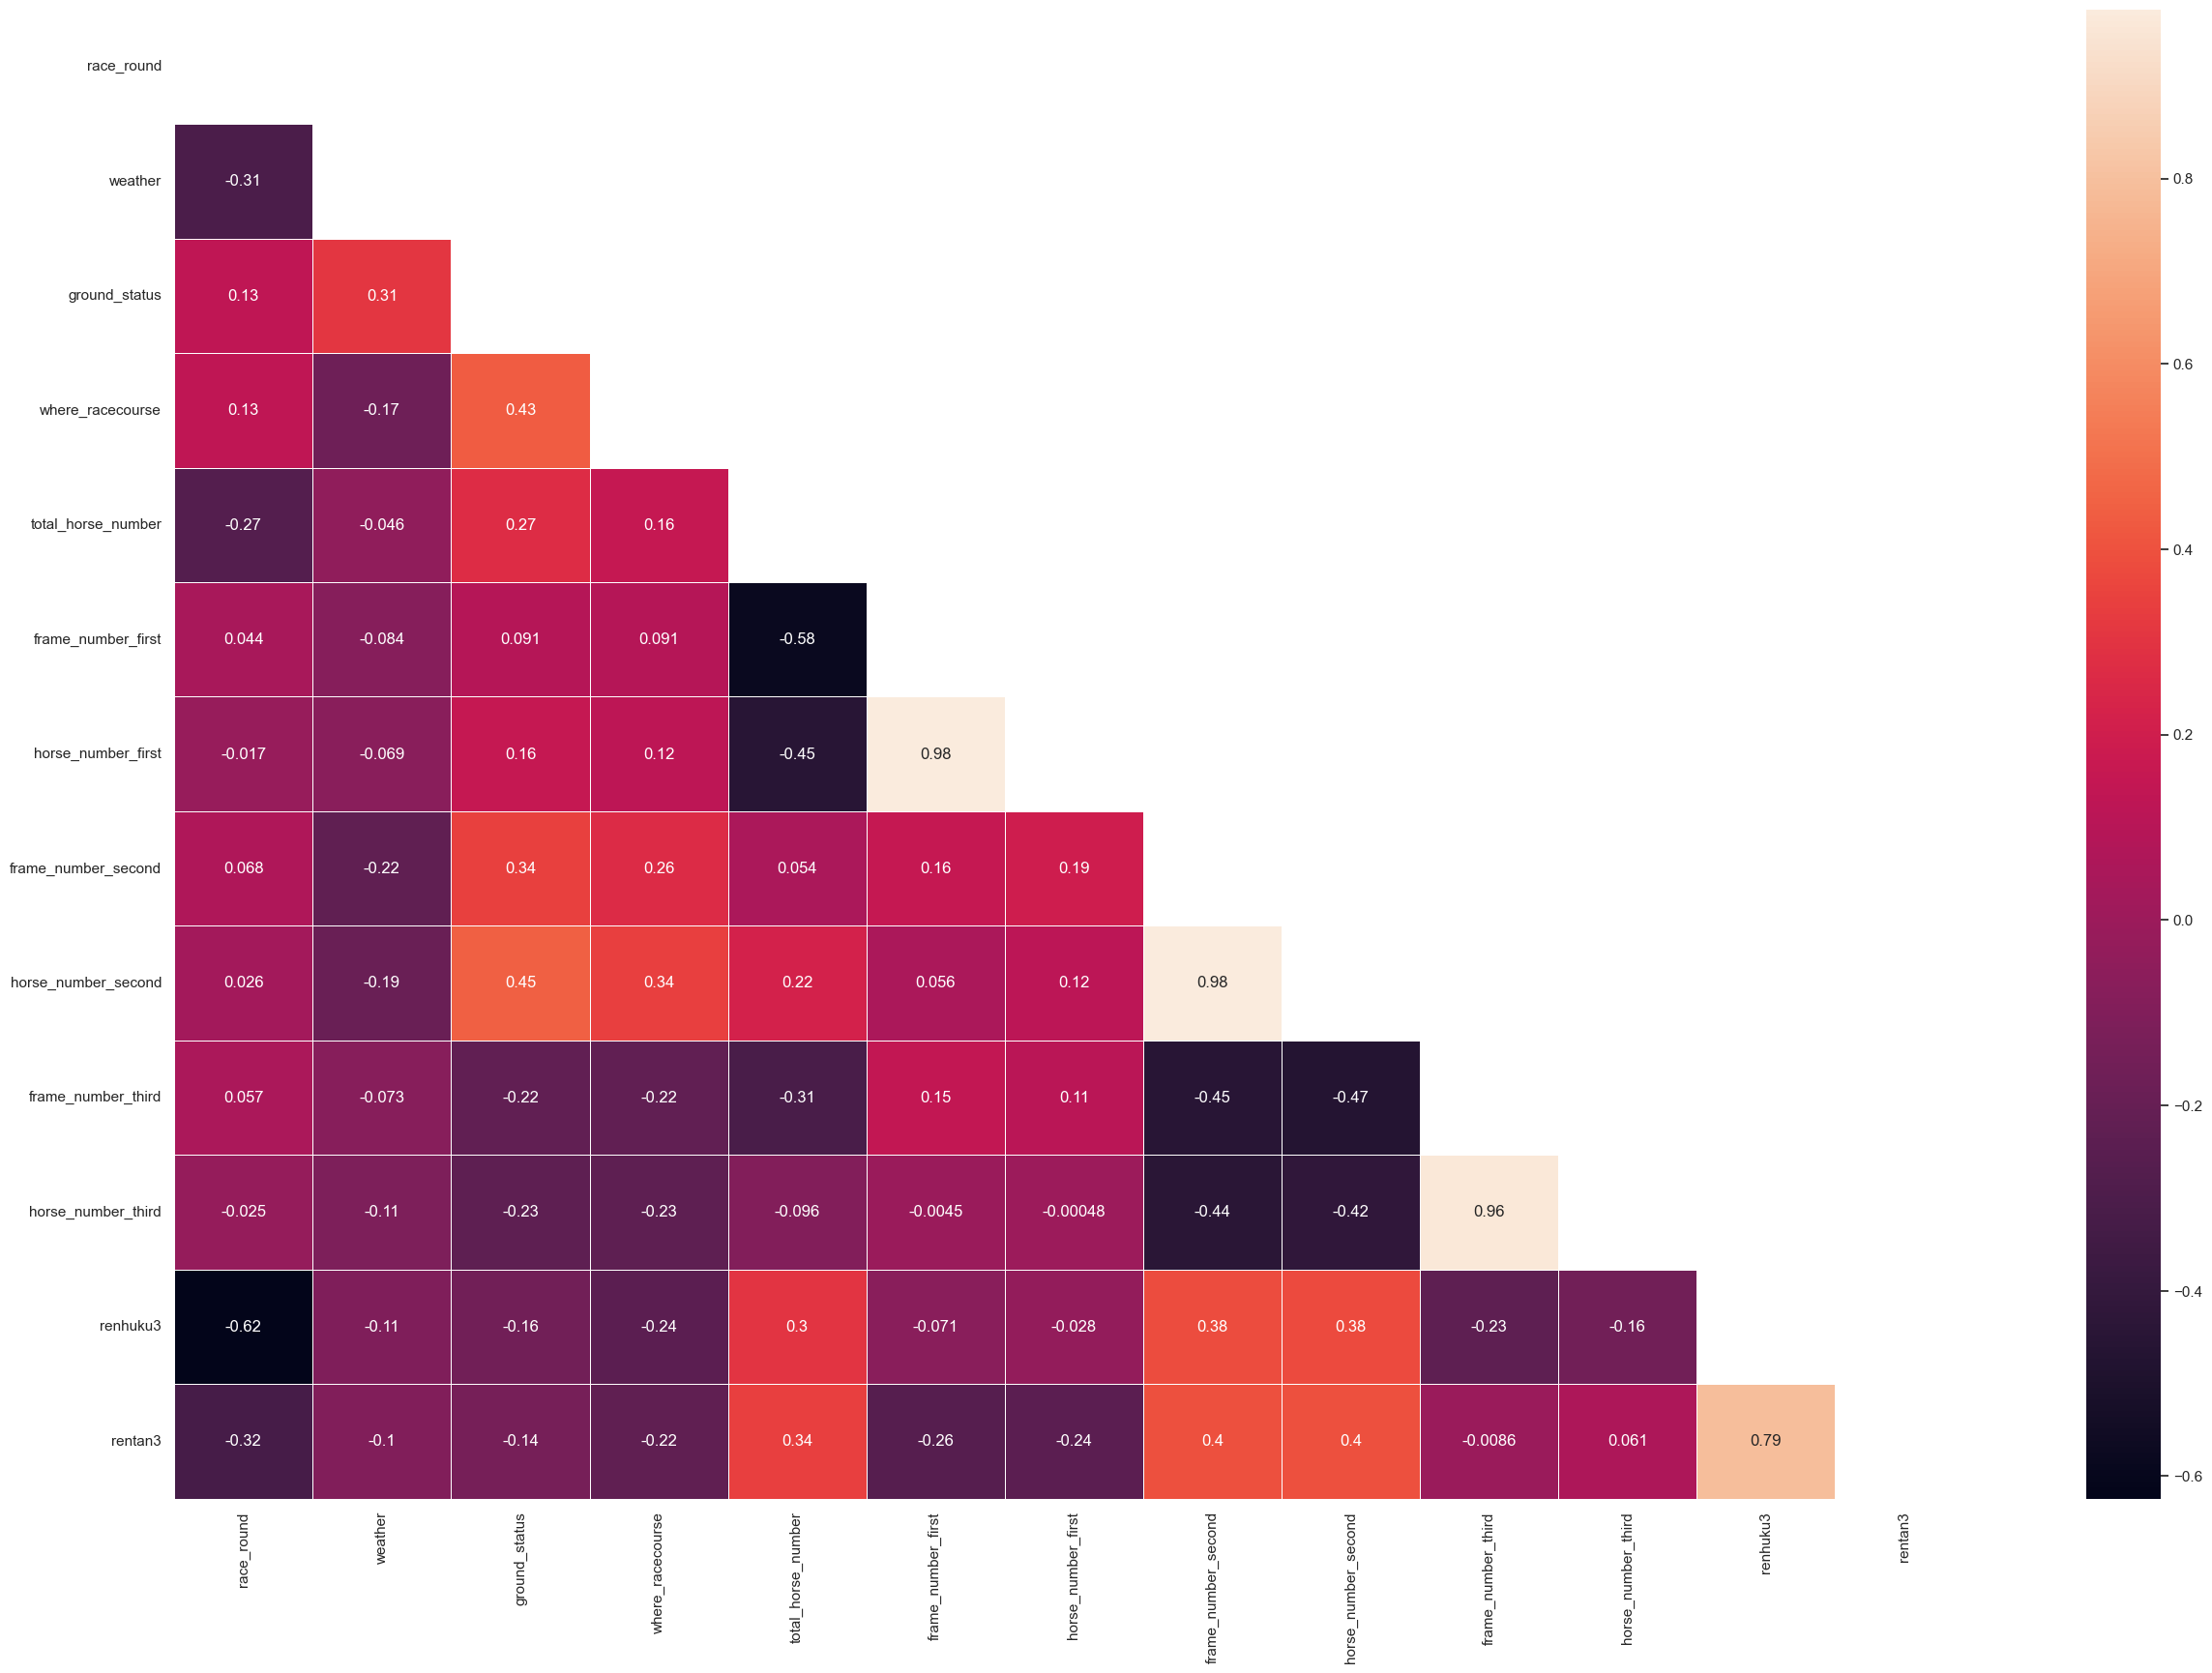

In [162]:
#最新のレースだけで見てみる
import seaborn as sns
sns.set(rc={'figure.figsize':(30,20)})
sns.set(style="white")
corr = race_df_tmp.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data = corr, mask = mask, linewidth = 0.5, annot = True)

In [158]:
race_df_tmp['renhuku3'].unique()

<IntegerArray>
[ 32390,  25530,  97140,  57160,  32350,   2040,    610,  44540,  21880,
   2840,  38790, 208890,   2060,  16410,   1880,  13500,   1580]
Length: 17, dtype: Int64

In [159]:
sns.rugplot(x='renhuku3', 
            y='horse_number_second',
						data=race_df_tmp,
						height=.03
						)
#ヒストグラム＋KDEも同時に描写する場合
sns.histplot(x='renhuku3',
             y='horse_number_second',
						data=race_df_tmp,
						kde=True
						)
plt.show()

TypeError: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'

<Figure size 3000x2000 with 1 Axes>

C:\Users\kawam\AppData\Local\Temp\ipykernel_7460\3337086903.py:1: UserWarning: 

`shade_lowest` has been replaced by `thresh`; setting `thresh=0.05.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(x='rentan3',
C:\Users\kawam\AppData\Local\Temp\ipykernel_7460\3337086903.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x='rentan3',


TypeError: loop of ufunc does not support argument 0 of type float which has no callable sqrt method

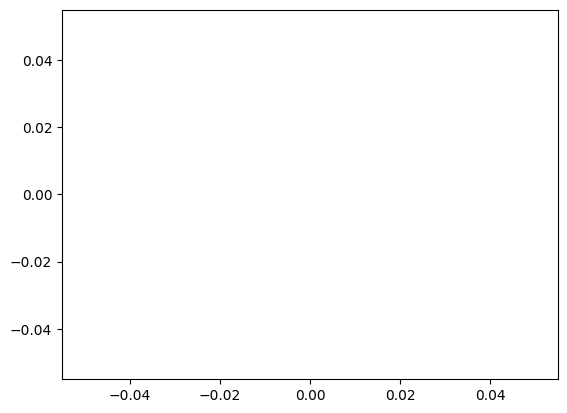

In [ ]:
sns.kdeplot(x='renhuku3',
						y='total_horse_number',
						data=race_df_tmp,
						shade=True,
						shade_lowest=False
						)

c:\Users\kawam\miniforge3\envs\keiba-django\lib\site-packages\seaborn\distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
c:\Users\kawam\miniforge3\envs\keiba-django\lib\site-packages\seaborn\distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),
c:\Users\kawam\miniforge3\envs\keiba-django\lib\site-packages\seaborn\distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
c:\Users\kawam\miniforge3\envs\keiba-django\lib\site-packages\seaborn\distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric 

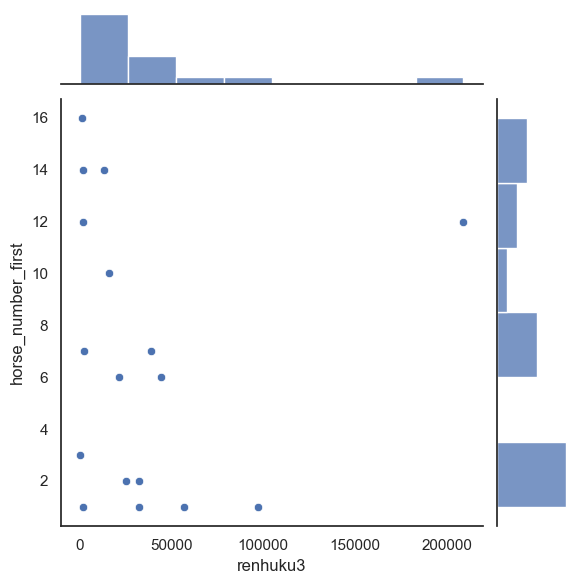

In [160]:
sns.jointplot(x='renhuku3',
              y='horse_number_first',
              data=race_df_tmp,
              #hue='ground_status',
              #height = 10
			  )

c:\Users\kawam\miniforge3\envs\keiba-django\lib\site-packages\seaborn\distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
c:\Users\kawam\miniforge3\envs\keiba-django\lib\site-packages\seaborn\distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),
c:\Users\kawam\miniforge3\envs\keiba-django\lib\site-packages\seaborn\distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
c:\Users\kawam\miniforge3\envs\keiba-django\lib\site-packages\seaborn\distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric 

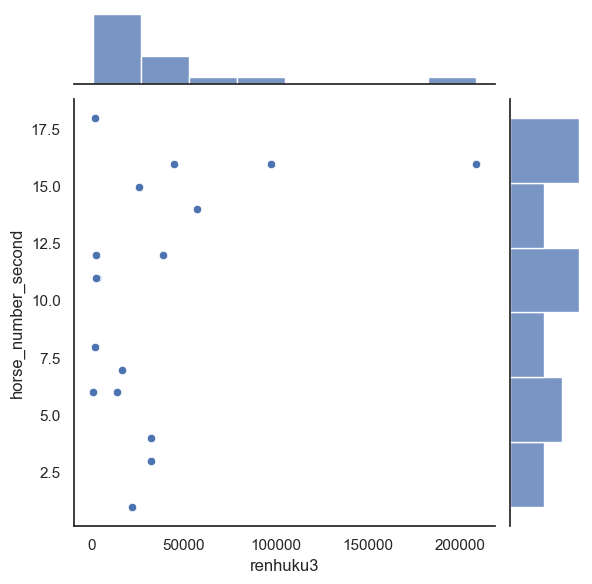

In [161]:
sns.jointplot(x='renhuku3',
              y='horse_number_second',
              data=race_df_tmp,
              #hue='ground_status',
              #height = 10
			  )

In [149]:
race_df_tmp['rentan3'] = race_df_tmp['rentan3'].astype(float)

In [150]:
# PairGridを作成する
g = sns.PairGrid(x='rentan3',
             data=race_df_tmp,
             #bins=100,
             )

# ヒストグラムのフォーマットを変更する
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
# 軸のフォーマットを通常の数字表示に戻す
g.axes.diagonal[-1].ticklabel_format(style='plain', useOffset=False)

# PairGridを表示する
plt.show()


TypeError: __init__() got an unexpected keyword argument 'x'

<Axes: xlabel='rentan3', ylabel='Count'>

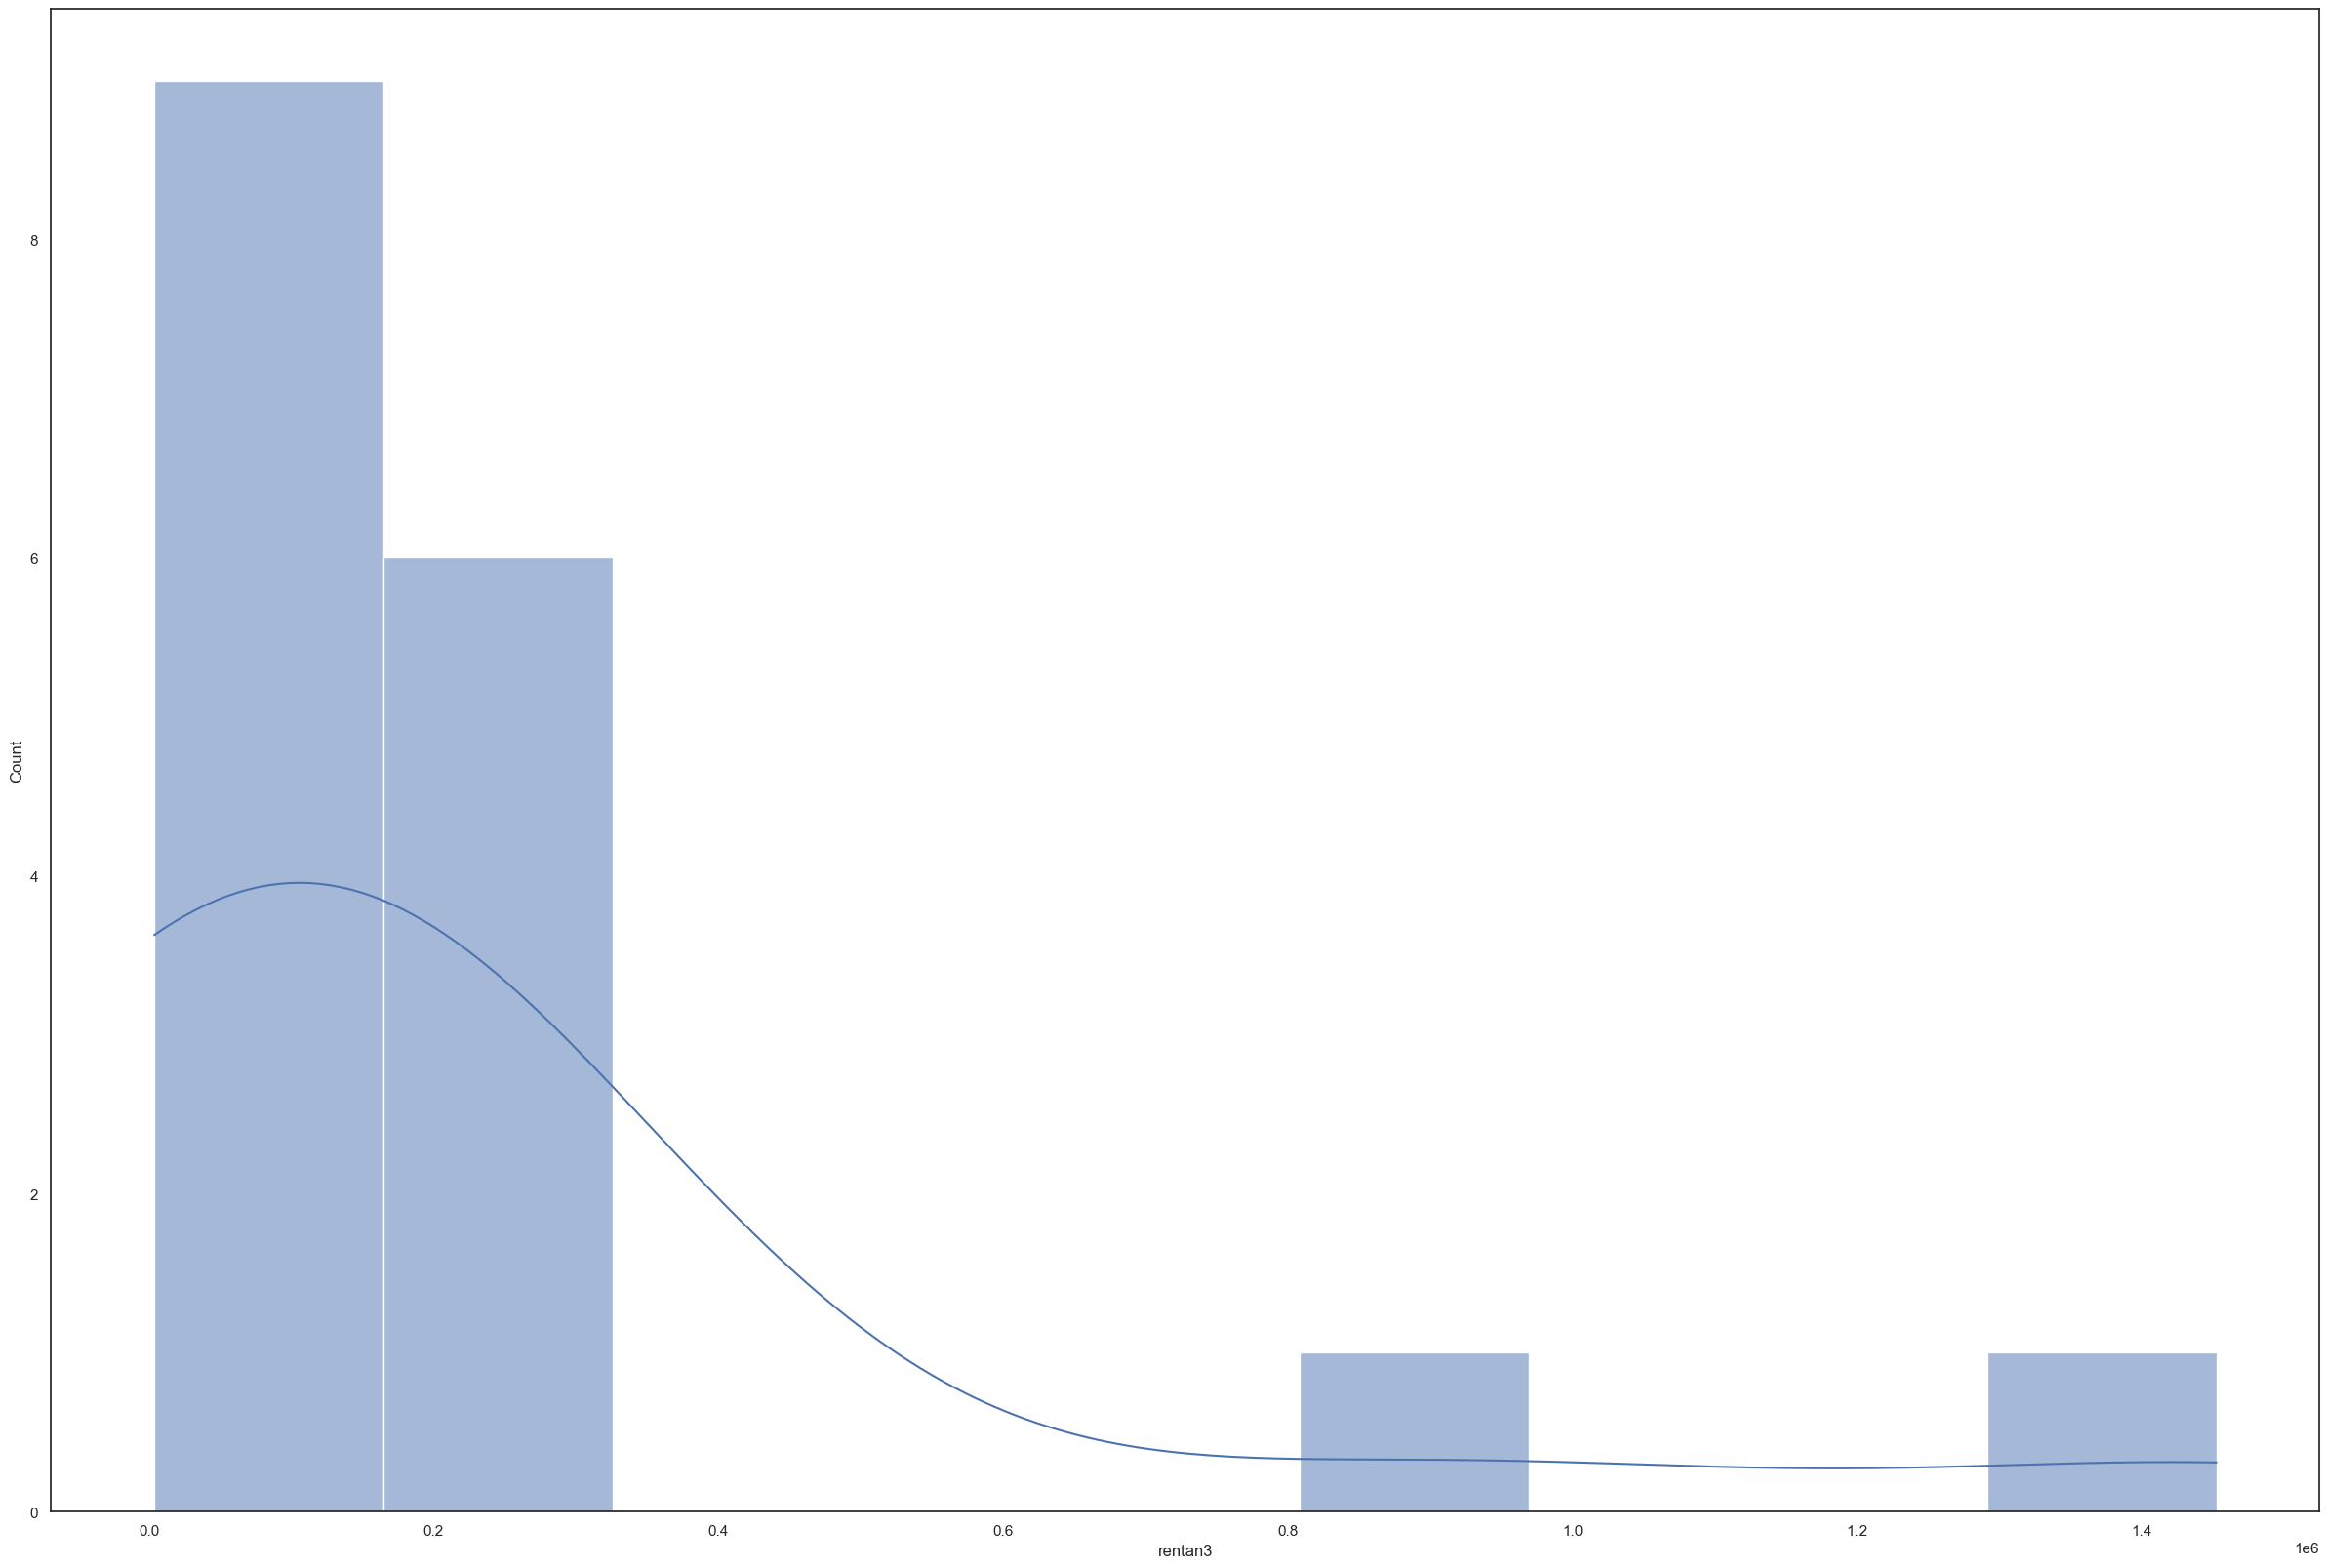

In [ ]:
sns.histplot(x='rentan3',
             data=race_df_tmp,
             #bins=100,
             kde=True
             )



In [165]:
horse_df_tmp =horse_df.drop(['race_id','horse_id', 'tamer_id', 'rider_id'],axis=1)

<Axes: >

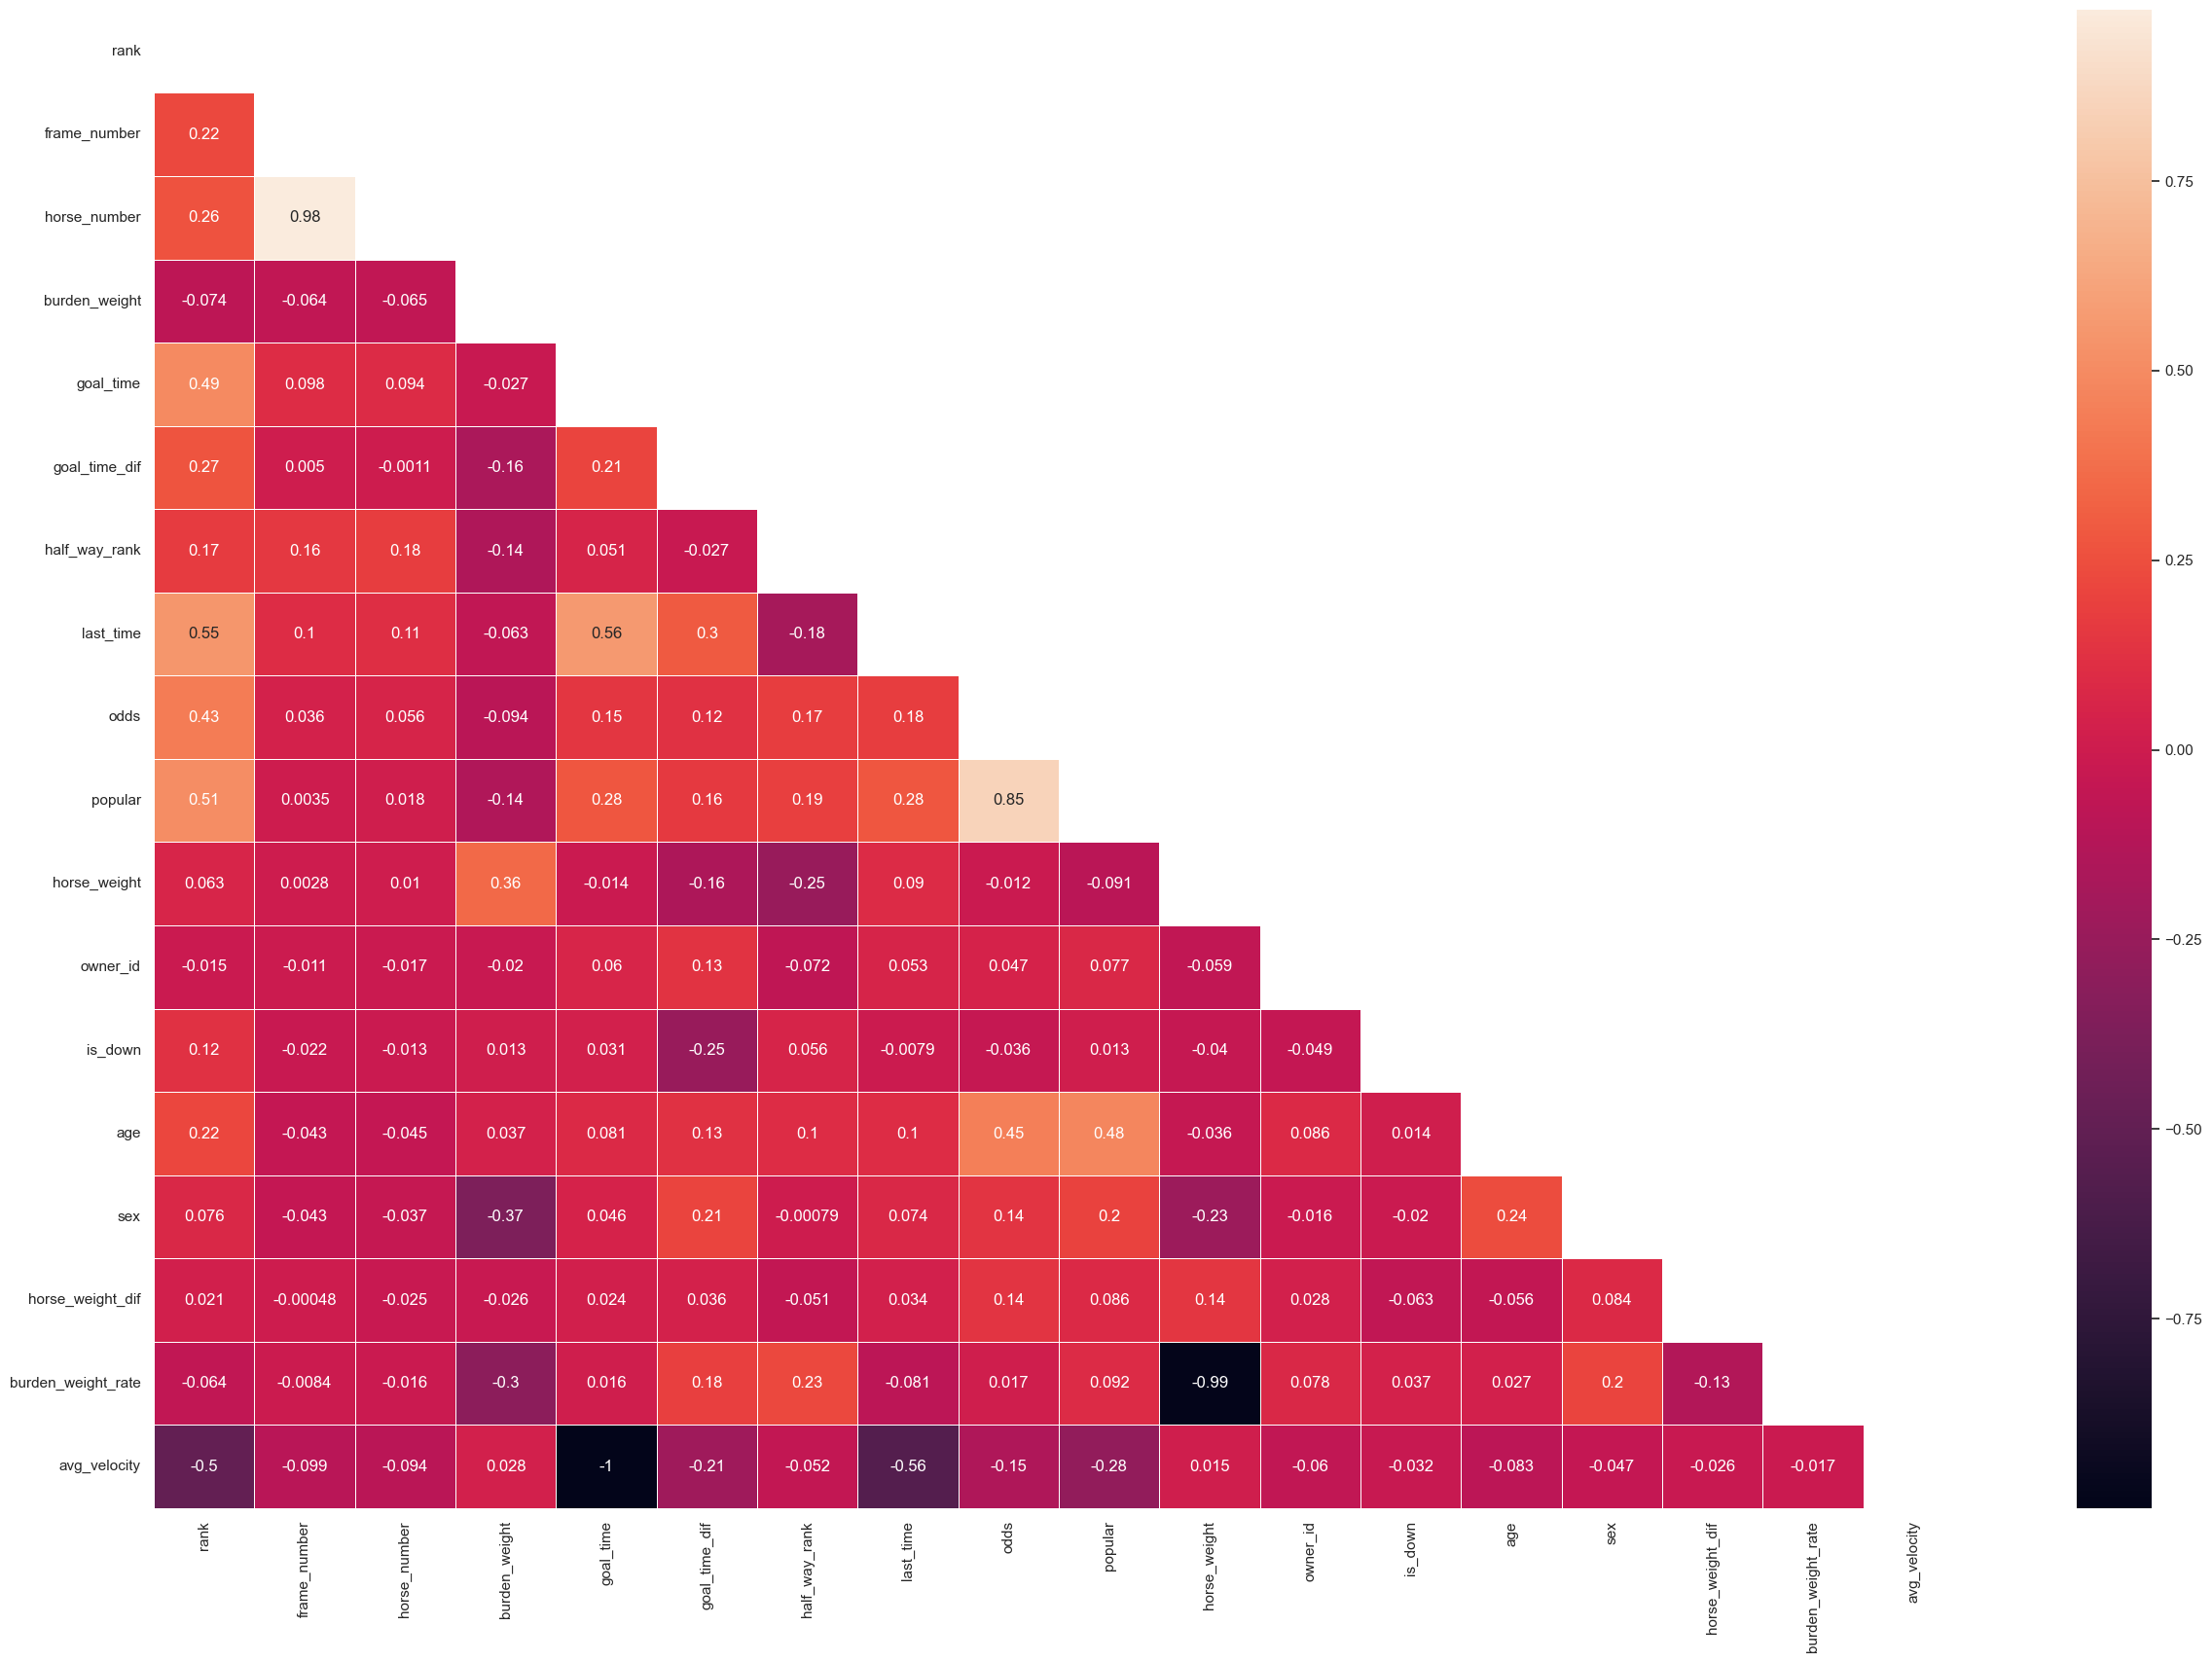

In [166]:
#最新のレースだけで見てみる
import seaborn as sns
sns.set(rc={'figure.figsize':(30,20)})
sns.set(style="white")
corr = horse_df_tmp.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data = corr, mask = mask, linewidth = 0.5, annot = True)